# Imports

In [1]:
import json
import pandas as pd
import numpy as np
from utils.globals import *
from utils.prompt_utils import AmbigousARCDataset
from utils.plot_utils import plot_item
from utils.eval import Eval, ModelEval
from utils.globals import *
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300

items = json.load(open('data/items_old_.json', 'rb'))
results_dir = 'data/results/random_cleanprompt'
data = json.load(open(f'{results_dir}/multiple_choice.json', 'r'))
data_random = json.load(open(f'{results_dir}/multiple_choice_random.json', 'r'))

dataset = AmbigousARCDataset(items, 
    task='discrimination', 
    random_mat=False, 
    seed=5
)
mc = Eval(data, dataset)

dataset_random = AmbigousARCDataset(items, 
    task='discrimination', 
    random_mat=True, 
    seed=45
)
mc_random = Eval(data_random, dataset_random)

print('Two Answer Options:')
mc.print()

print('Three answer options')
mc_random.print()

[0.4888888888888889, 0.4444444444444444, 0.6444444444444445, 0.5333333333333333, 0.4666666666666667, 0.5555555555555556, 0.5555555555555556, 0.5555555555555556, 0.5111111111111111, 0.4888888888888889, 0.5777777777777777, 0.4888888888888889, 0.4888888888888889]


ValueError: All arrays must be of the same length

In [13]:
for i, m in enumerate(mc_random.excluded_models_prop_test):
    if 'gemm' in m.name:
        print(i, m.name)
        print(m.answer_props)
        print(f'Concept responses: {m.concept_responses}')
        print(f'Matrix responses: {m.matrix_responses}\n')


6 google/gemma-2-27b-it
{'a': 0.6222222222222222, 'b': 0.13333333333333333, 'c': 0.24444444444444444}
Concept responses: 0.6
Matrix responses: 0.3111111111111111

9 google/gemma-2-9b-it
{'a': 0.5555555555555556, 'b': 0.3111111111111111, 'c': 0.13333333333333333}
Concept responses: 0.5777777777777777
Matrix responses: 0.3333333333333333



In [14]:
print(AmbigousARCDataset(items, batch_size=1, task='discrimination', random_mat=True, seed=42).x[0])

EXAMPLE TASK:

Input 1: [3 0 3] [3 0 3] [7 0 3]
Output 1: [3 0 3] [3 0 3] [7 0 7]
Input 2: [3 0 3] [7 0 3] [3 0 3]
Output 2:

(a) [3 3 3] [7 0 3] [3 0 3]
(b) [3 0 3] [7 0 7] [3 0 3]
(c) [3 0 3] [7 0 3] [3 0 7]

Answer: (b)

TEST TASK:

Input 1: [0 3 0] [2 3 2] [0 3 0]
Output 1: [0 3 0] [2 2 2] [0 3 0]
Input 2: [3 0 0] [3 1 1] [3 0 0]
Output 2:

(a) [3 0 0] [1 1 1] [3 0 0]
(b) [2 3 3] [0 3 3] [0 3 0]
(c) [3 0 0] [3 2 1] [3 0 0]

Answer: (


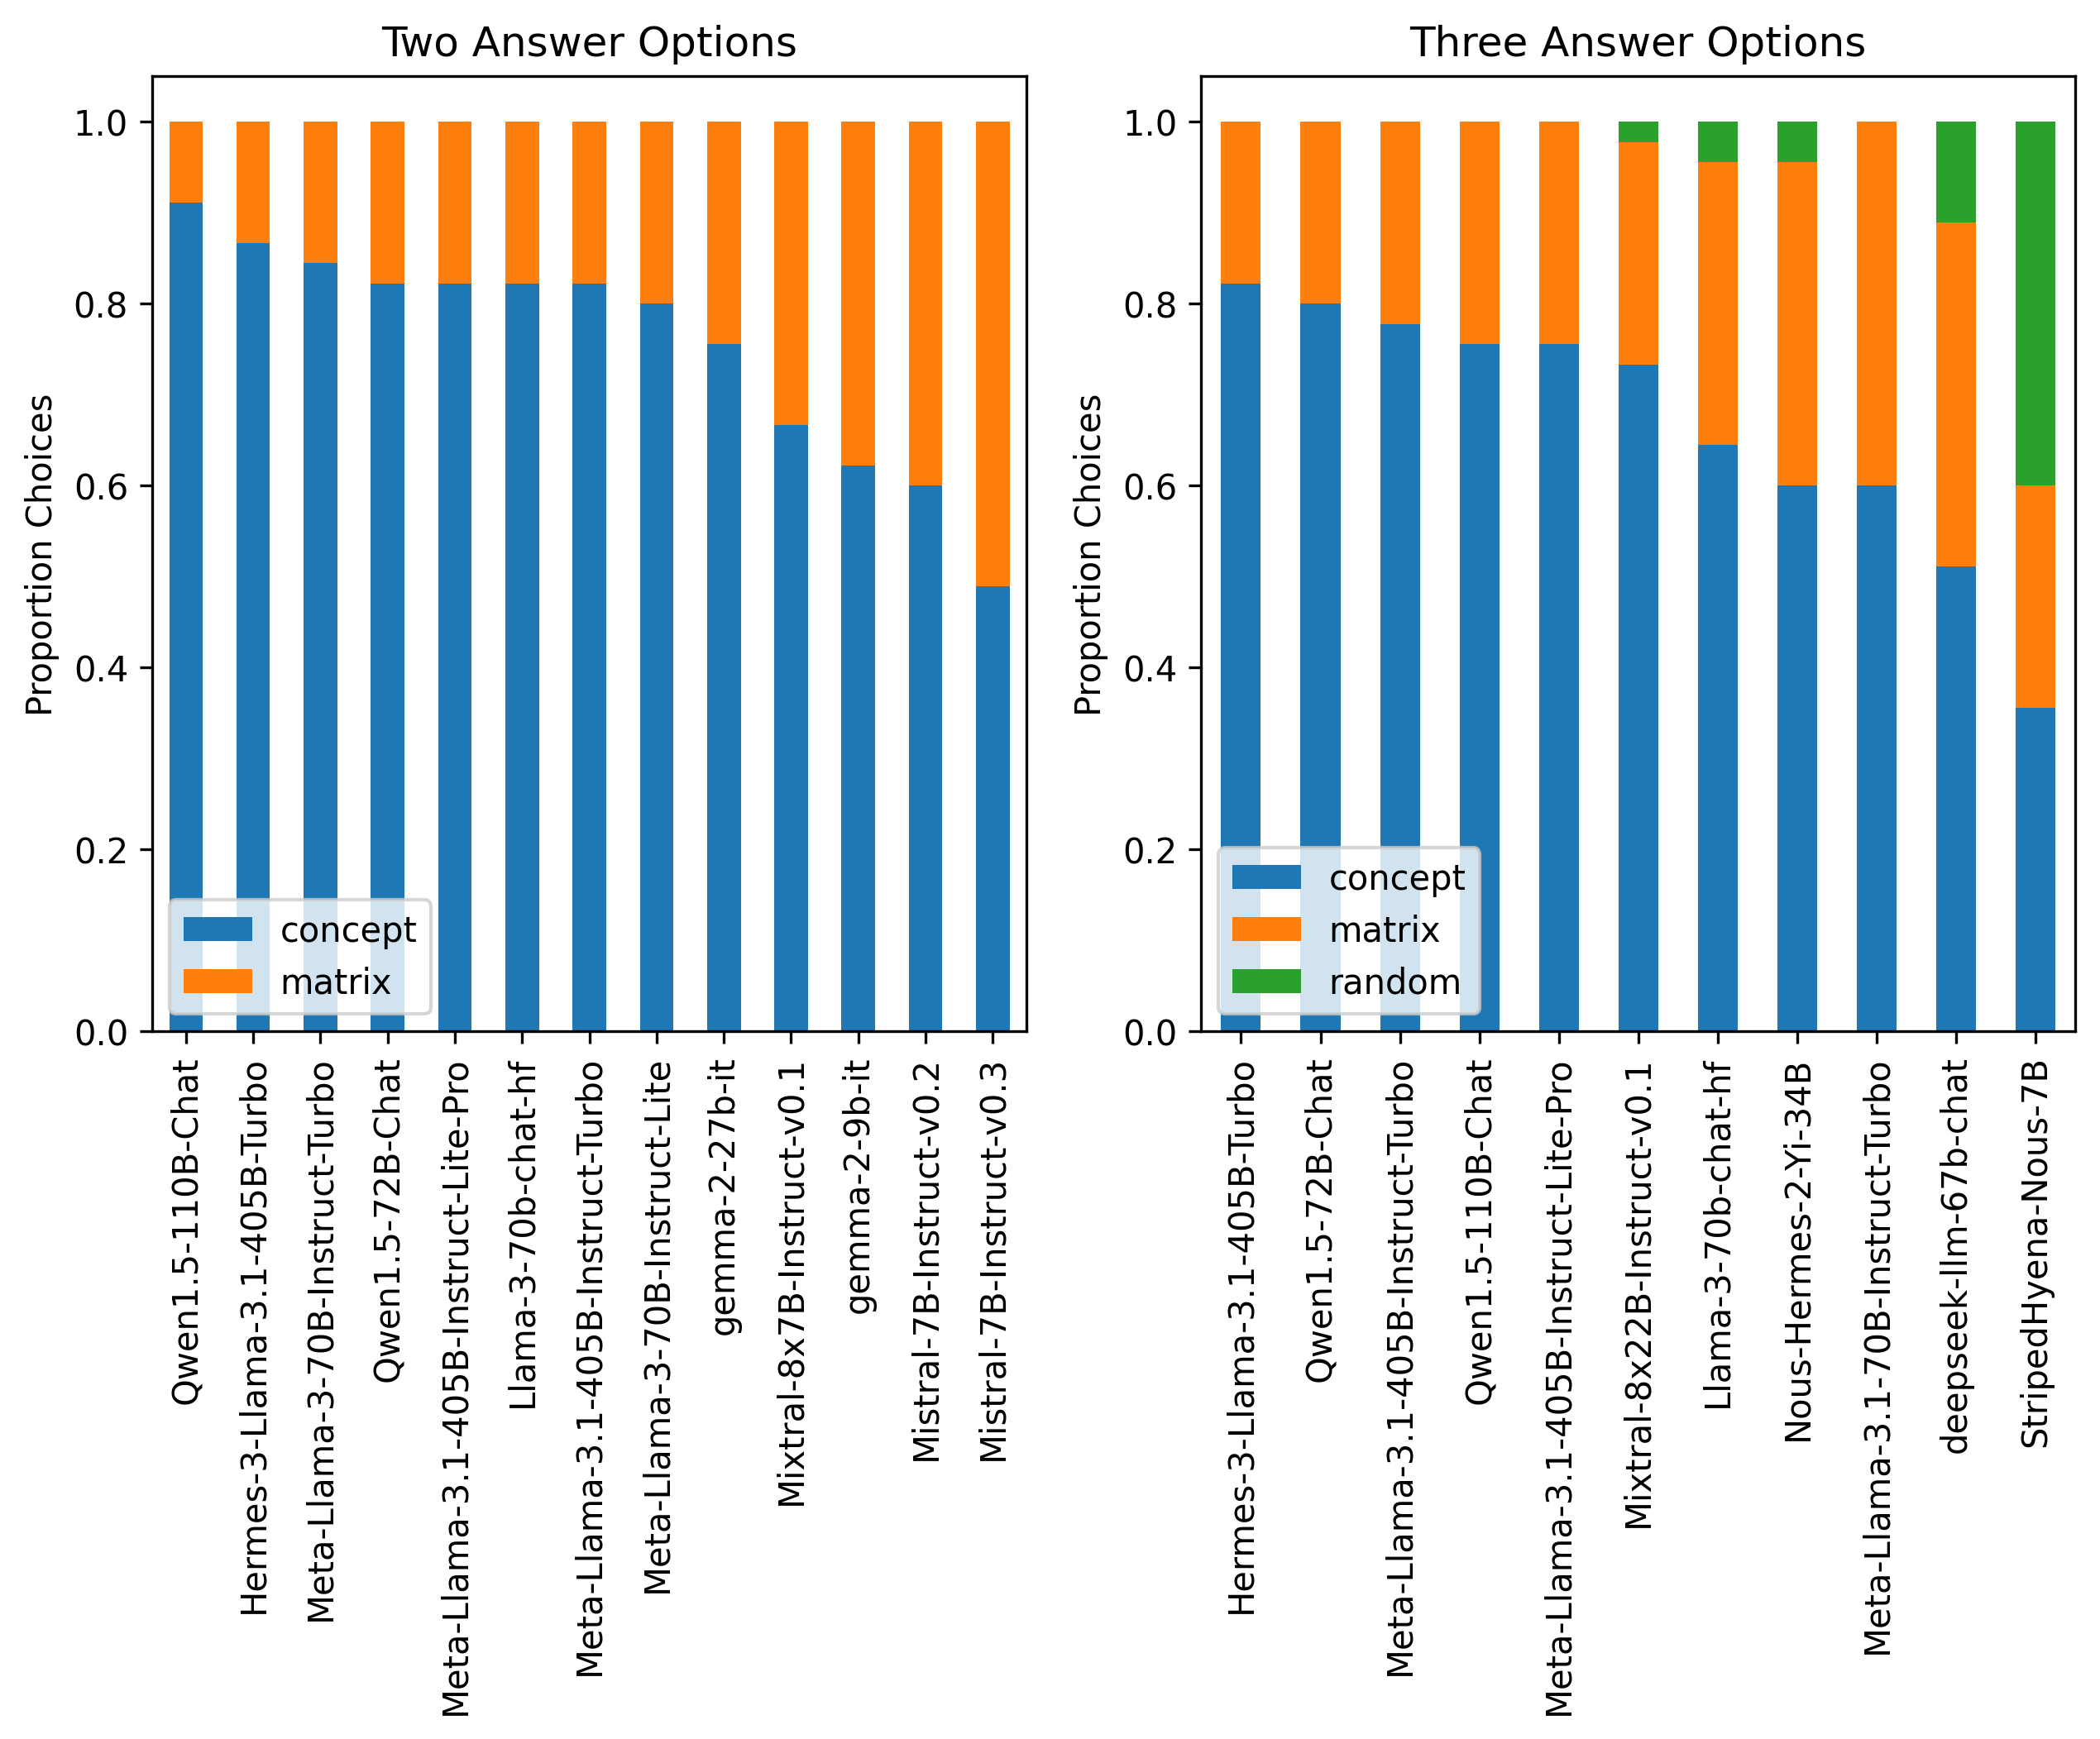

In [15]:
df_stacked_random = pd.DataFrame({
    'concept': mc_random.concept_responses,
    'matrix': mc_random.matrix_responses,
    'random': mc_random.random_responses
})
df_stacked_random.index = [model.split('/')[1] for model in mc_random.models_names]
df_stacked_random = df_stacked_random.sort_values(by='concept', ascending=False)

df_stacked = pd.DataFrame({
    'concept': mc.concept_responses,
    'matrix': mc.matrix_responses,
})
df_stacked.index = [model.split('/')[1] for model in mc.models_names]
df_stacked = df_stacked.sort_values(by='concept', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].set_title('Two Answer Options')
df_stacked.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_ylabel('Proportion Choices')
ax[0].legend(loc='lower left')
ax[0].set_xticks(np.arange(0, len(df_stacked), 1))
ax[0].set_xticklabels(df_stacked.index, rotation=90)

ax[1].set_title('Three Answer Options')
df_stacked_random.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_ylabel('Proportion Choices')
ax[1].legend(loc='lower left')
ax[1].set_xticks(np.arange(0, len(df_stacked_random), 1))
ax[1].set_xticklabels(df_stacked_random.index, rotation=90)
plt.show()


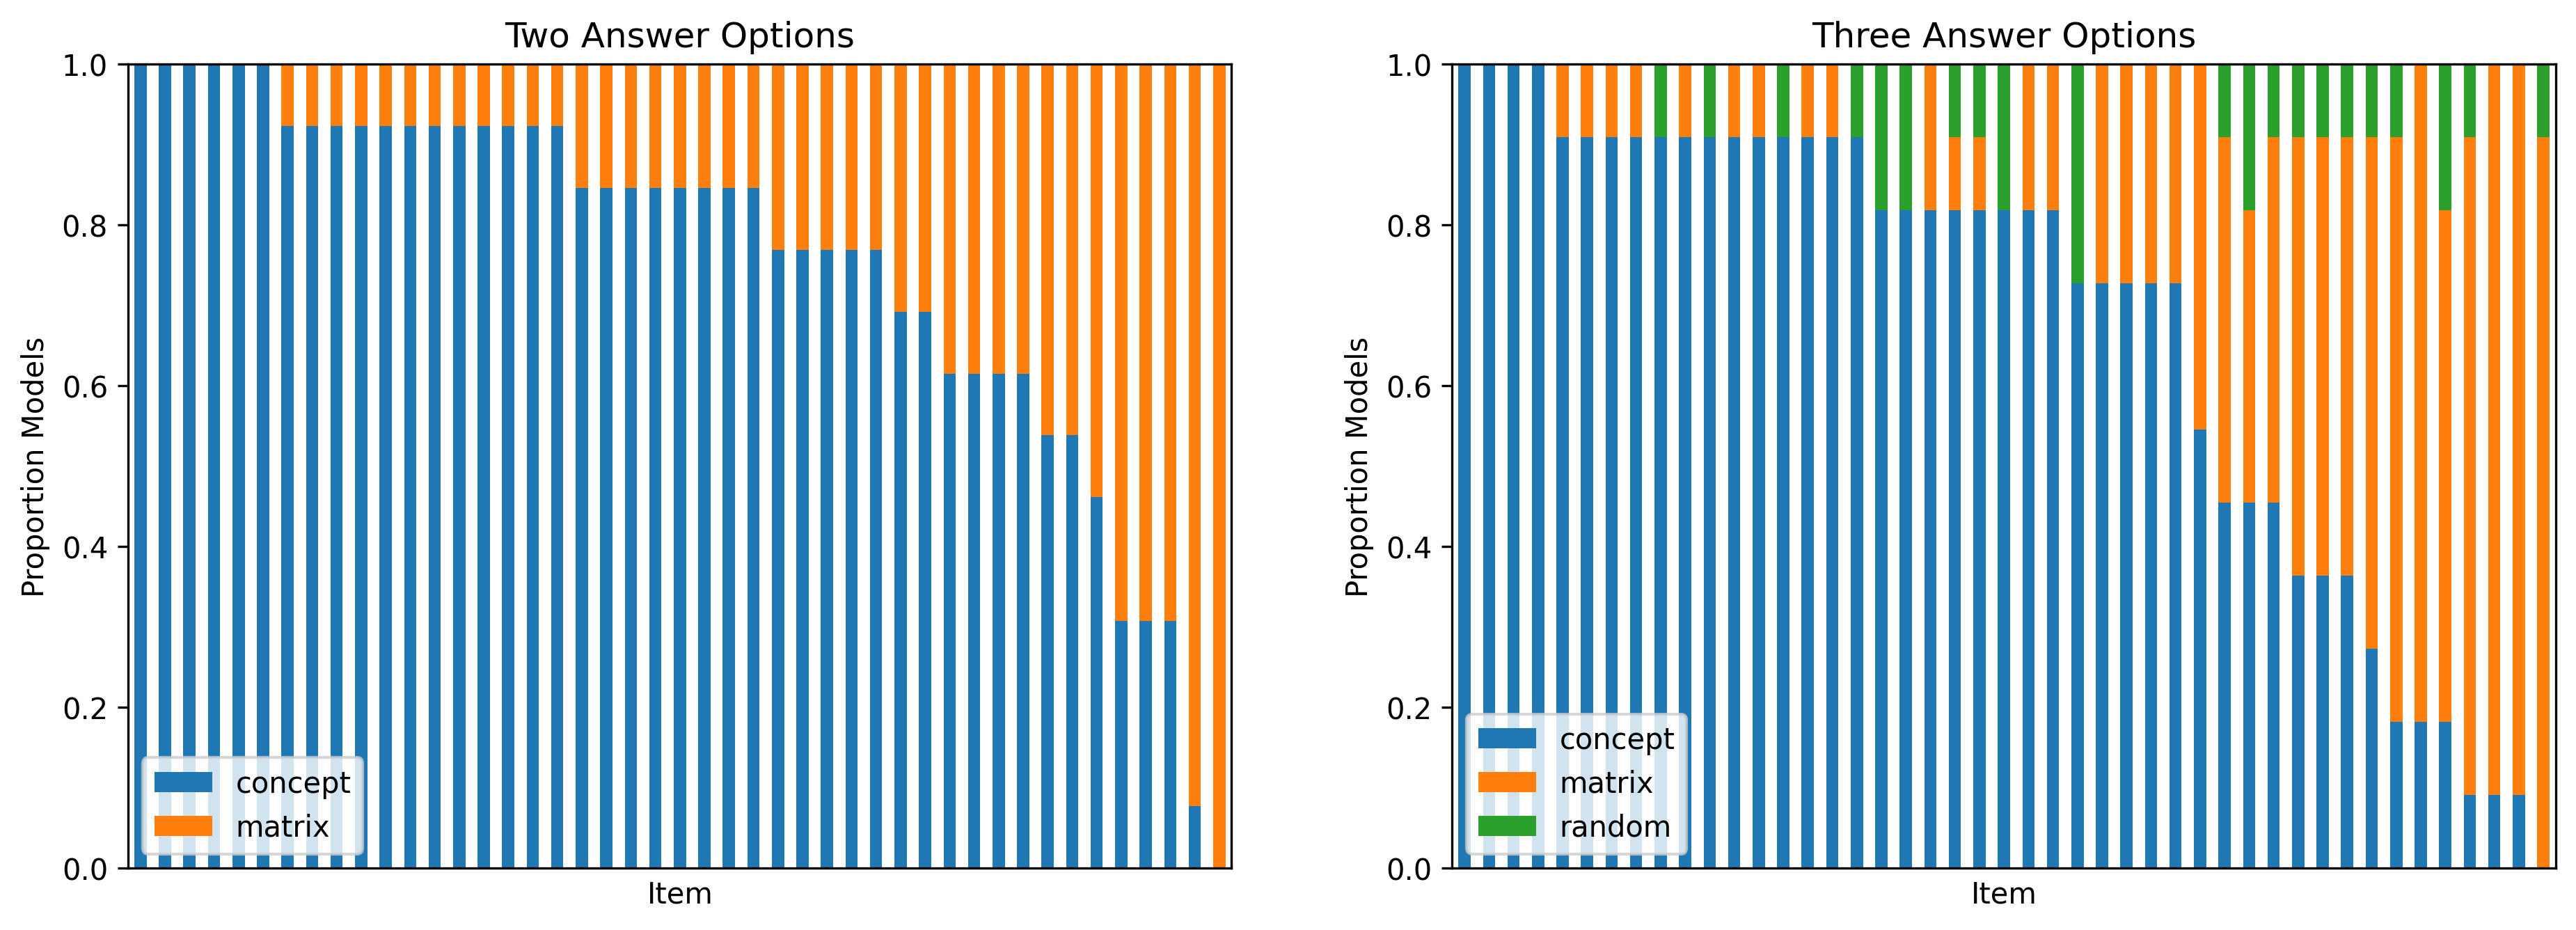

In [16]:
df_stacked_items = pd.DataFrame({
    'concept': mc.df.groupby('item_id')['concept_response'].mean(),
    'matrix': mc.df.groupby('item_id')['matrix_response'].mean(),
})
df_stacked_items = df_stacked_items.sort_values(by='concept', ascending=False)

df_stacked_items_random = pd.DataFrame({
    'concept': mc_random.df.groupby('item_id')['concept_response'].mean(),
    'matrix': mc_random.df.groupby('item_id')['matrix_response'].mean(),
    'random': mc_random.df.groupby('item_id')['random_response'].mean()
})
df_stacked_items_random = df_stacked_items_random.sort_values(by='concept', ascending=False)

fig, ax = plt.subplots(1, 2, figsize=(15, 5))
ax[0].set_title('Two Answer Options')
df_stacked_items.plot(kind='bar', stacked=True, ax=ax[0])
ax[0].set_ylabel('Proportion Models')
ax[0].legend(loc='lower left')
ax[0].set_xticks([])
ax[0].set_xlabel('Item')
ax[0].set_ylim(0, 1)

ax[1].set_title('Three Answer Options')
df_stacked_items_random.plot(kind='bar', stacked=True, ax=ax[1])
ax[1].set_ylabel('Proportion Models')
ax[1].legend(loc='lower left')
ax[1].set_xticks([])
ax[1].set_xlabel('Item')
ax[1].set_ylim(0, 1)

plt.show()

In [17]:
def plot_most_common(n_choices, choice, top=3):
    df = df_stacked_items_random if n_choices == 3 else df_stacked_items
    df = df.sort_values(by=choice, ascending=False)[:top]
    for i in range(top):      
        mc_random.dataset.plot(df.index[i], f'Item: {df.index[i]} {choice}: {df.iloc[i][choice] * 100:.2f}%')

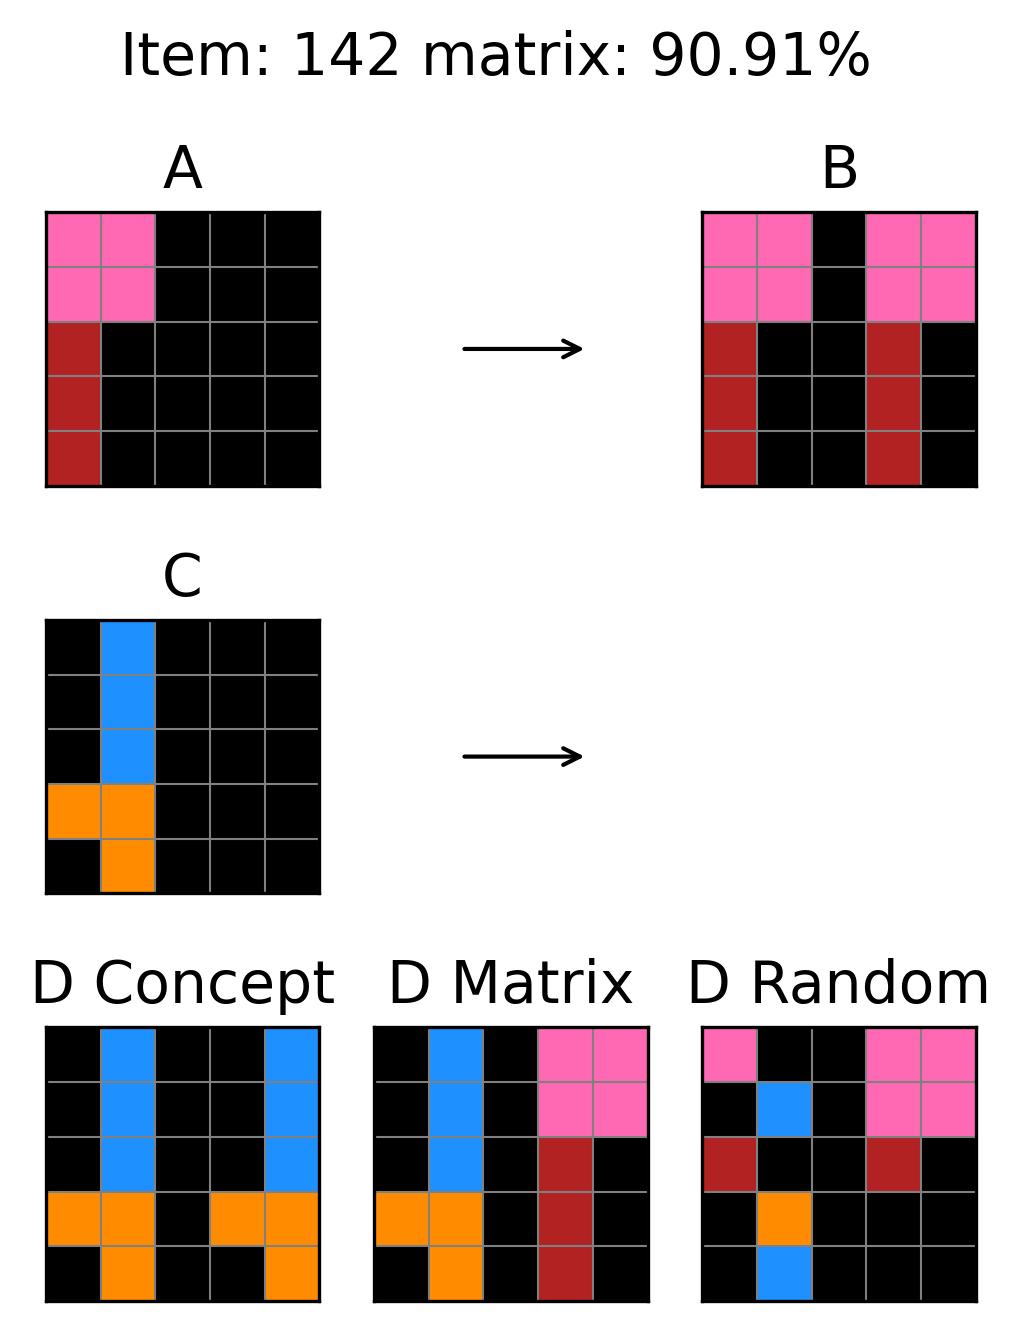

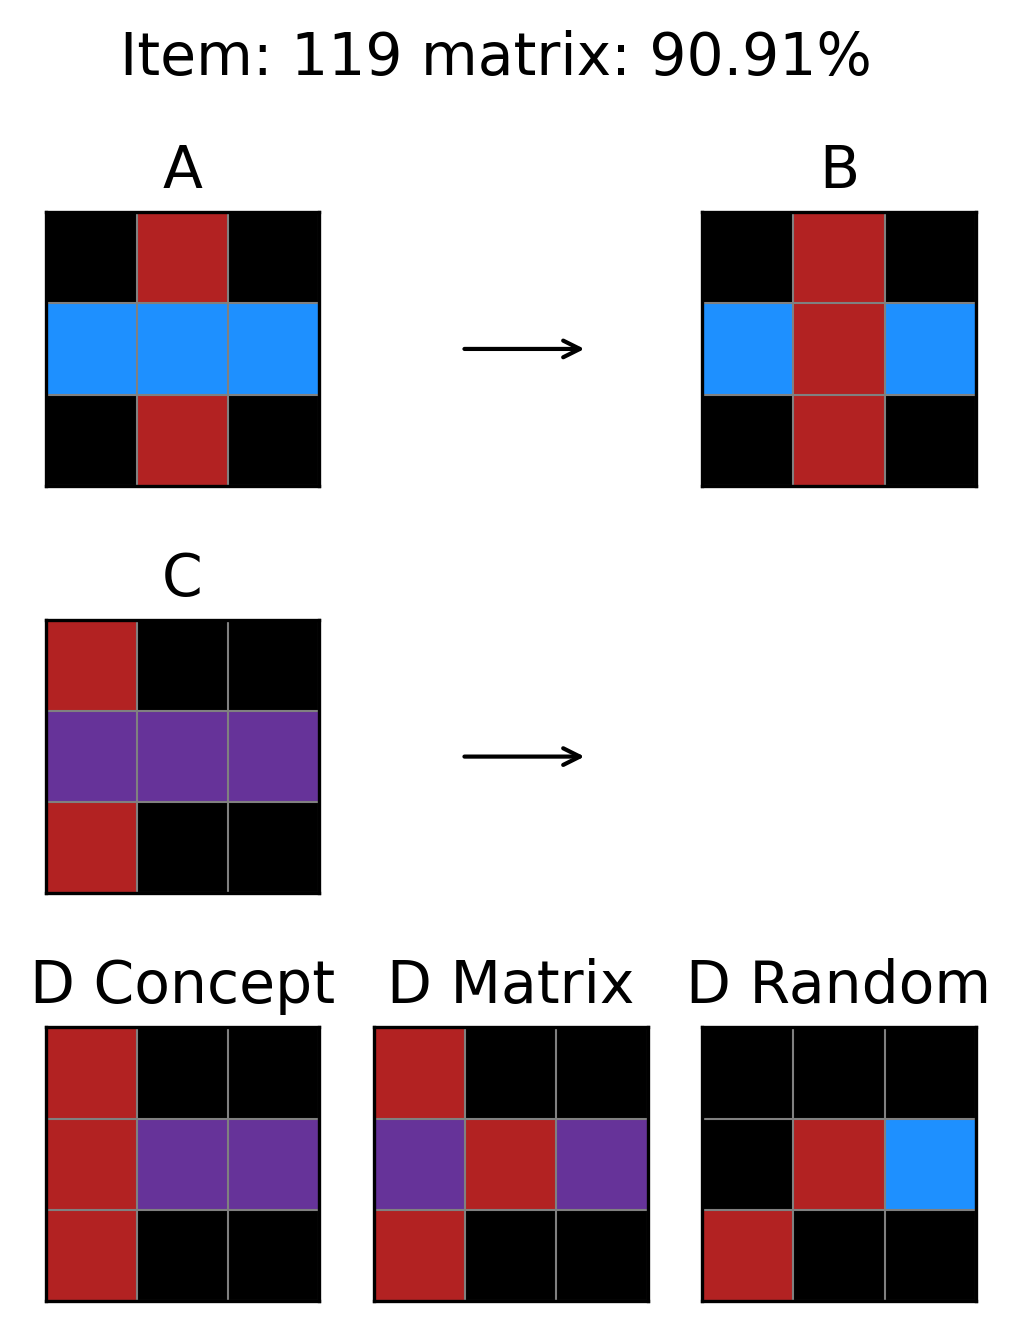

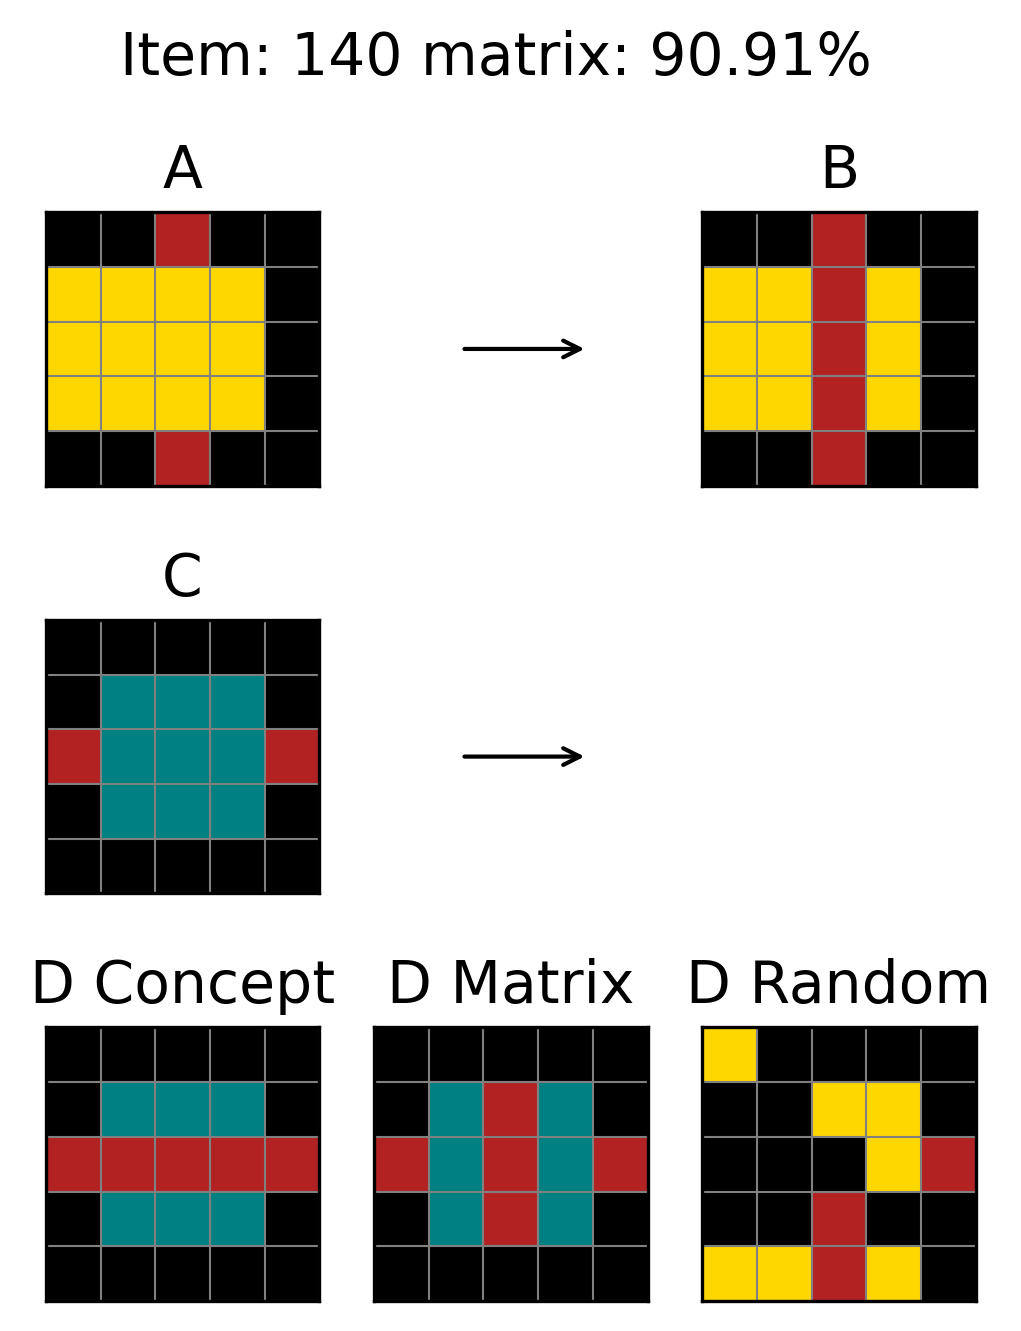

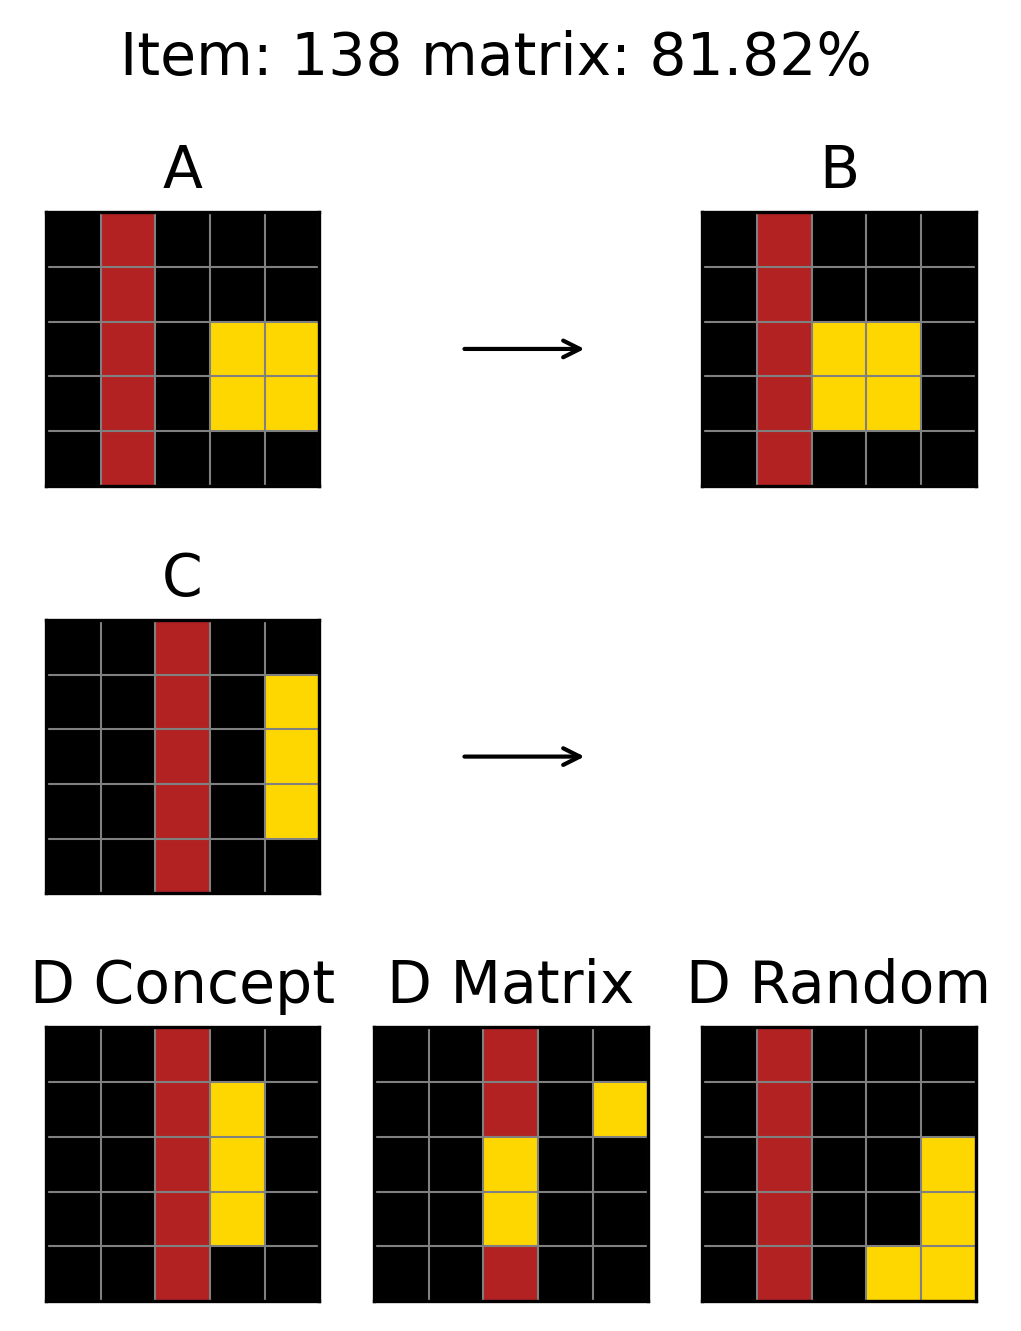

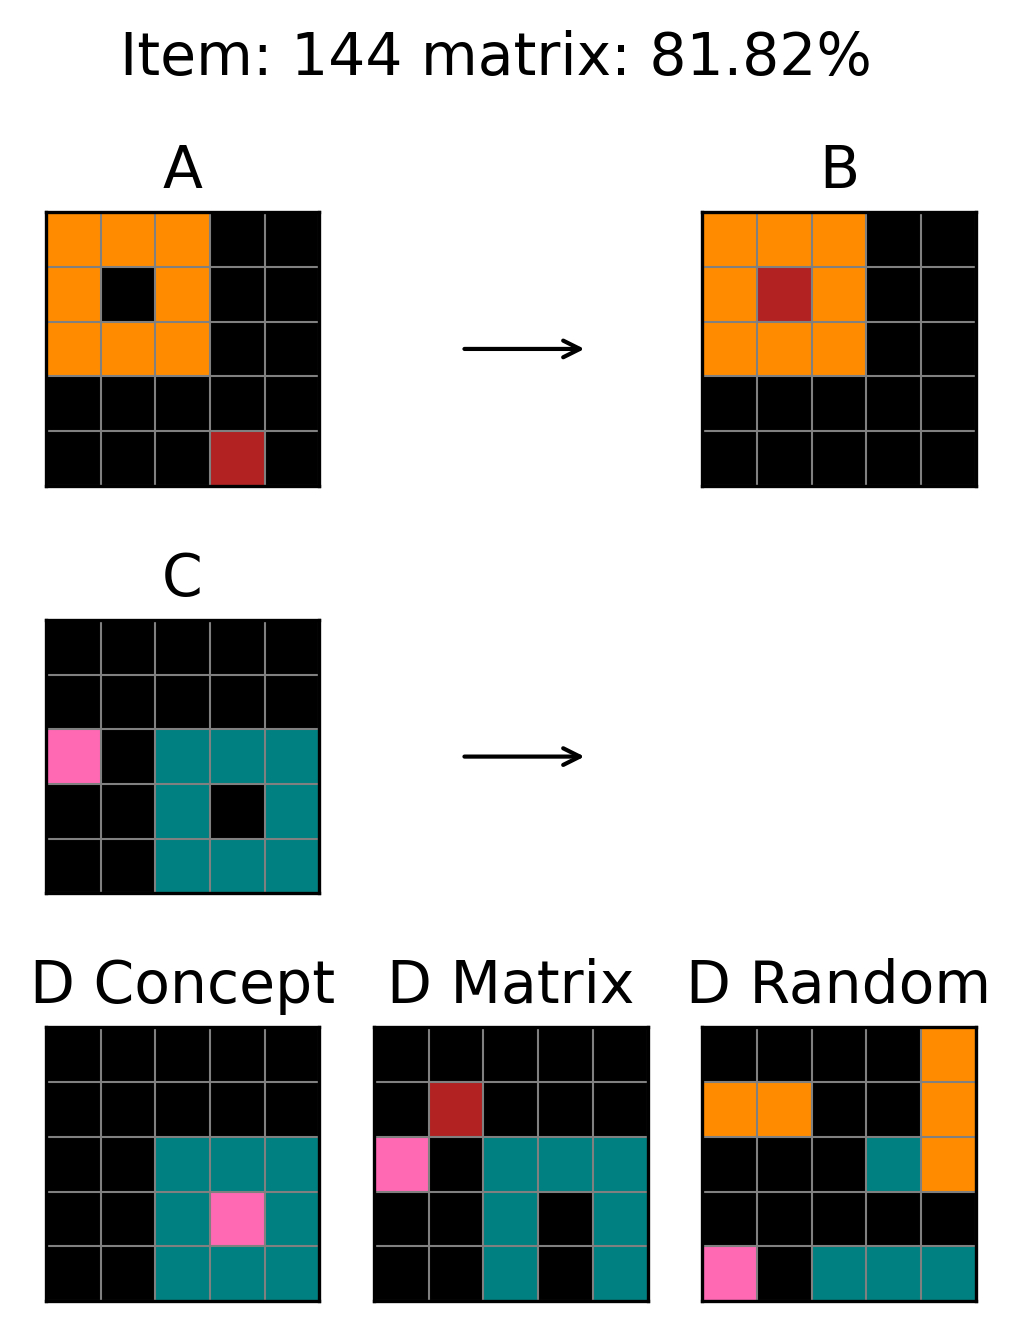

In [18]:
plot_most_common(3, 'matrix', top=5)

# Concept recognition

In [45]:
results_dir = 'data/results'
data_abcd = json.load(open(f'{results_dir}/concept_task_3.json', 'r'))
dataset_abcd = AmbigousARCDataset(items, 
    task='recognition', 
    concept_answer_n=4,
    seed=12
)
abcd = Eval('data/results/concept_task_3.json', prop_test_thresh=None, no_response_thresh=False)

data_all = json.load(open(f'{results_dir}/concept_task_all.json', 'r'))
dataset_all = AmbigousARCDataset(items, 
    task='recognition', 
    concept_answer_n=None,
    seed=9123
)
abcd_all = Eval(data_all, dataset=dataset_all, prop_test_thresh=None, no_response_thresh=False)

print('Four Answer Options:')
abcd.print()

print('All Answer Options')
abcd_all.print()


Four Answer Options:


Number of models: 41
Accuracy: 0.30

All Answer Options


Number of models: 41
Accuracy: 0.08

In [35]:
print(dataset_abcd.x[0])

EXAMPLE TASK:

Input 1: [3 0 3] [3 0 3] [7 0 3]
Output 1: [3 0 3] [3 0 3] [7 0 7]
Input 2: [3 0 3] [7 0 3] [3 0 3]
Output 2: [3 0 3] [7 0 7] [3 0 3]

Concept:
(a) Other
(b) Filled and not filled
(c) Order
(d) Copy

Answer: (d)

TEST TASK:

Input 1: [0 3 0] [2 3 2] [0 3 0]
Output 1: [0 3 0] [2 2 2] [0 3 0]
Input 2: [3 0 0] [3 1 1] [3 0 0]
Output 2: [3 0 0] [1 1 1] [3 0 0]

Concept:
(a) Copy
(b) Top and bottom 3d
(c) Other
(d) Clean up

Answer: (


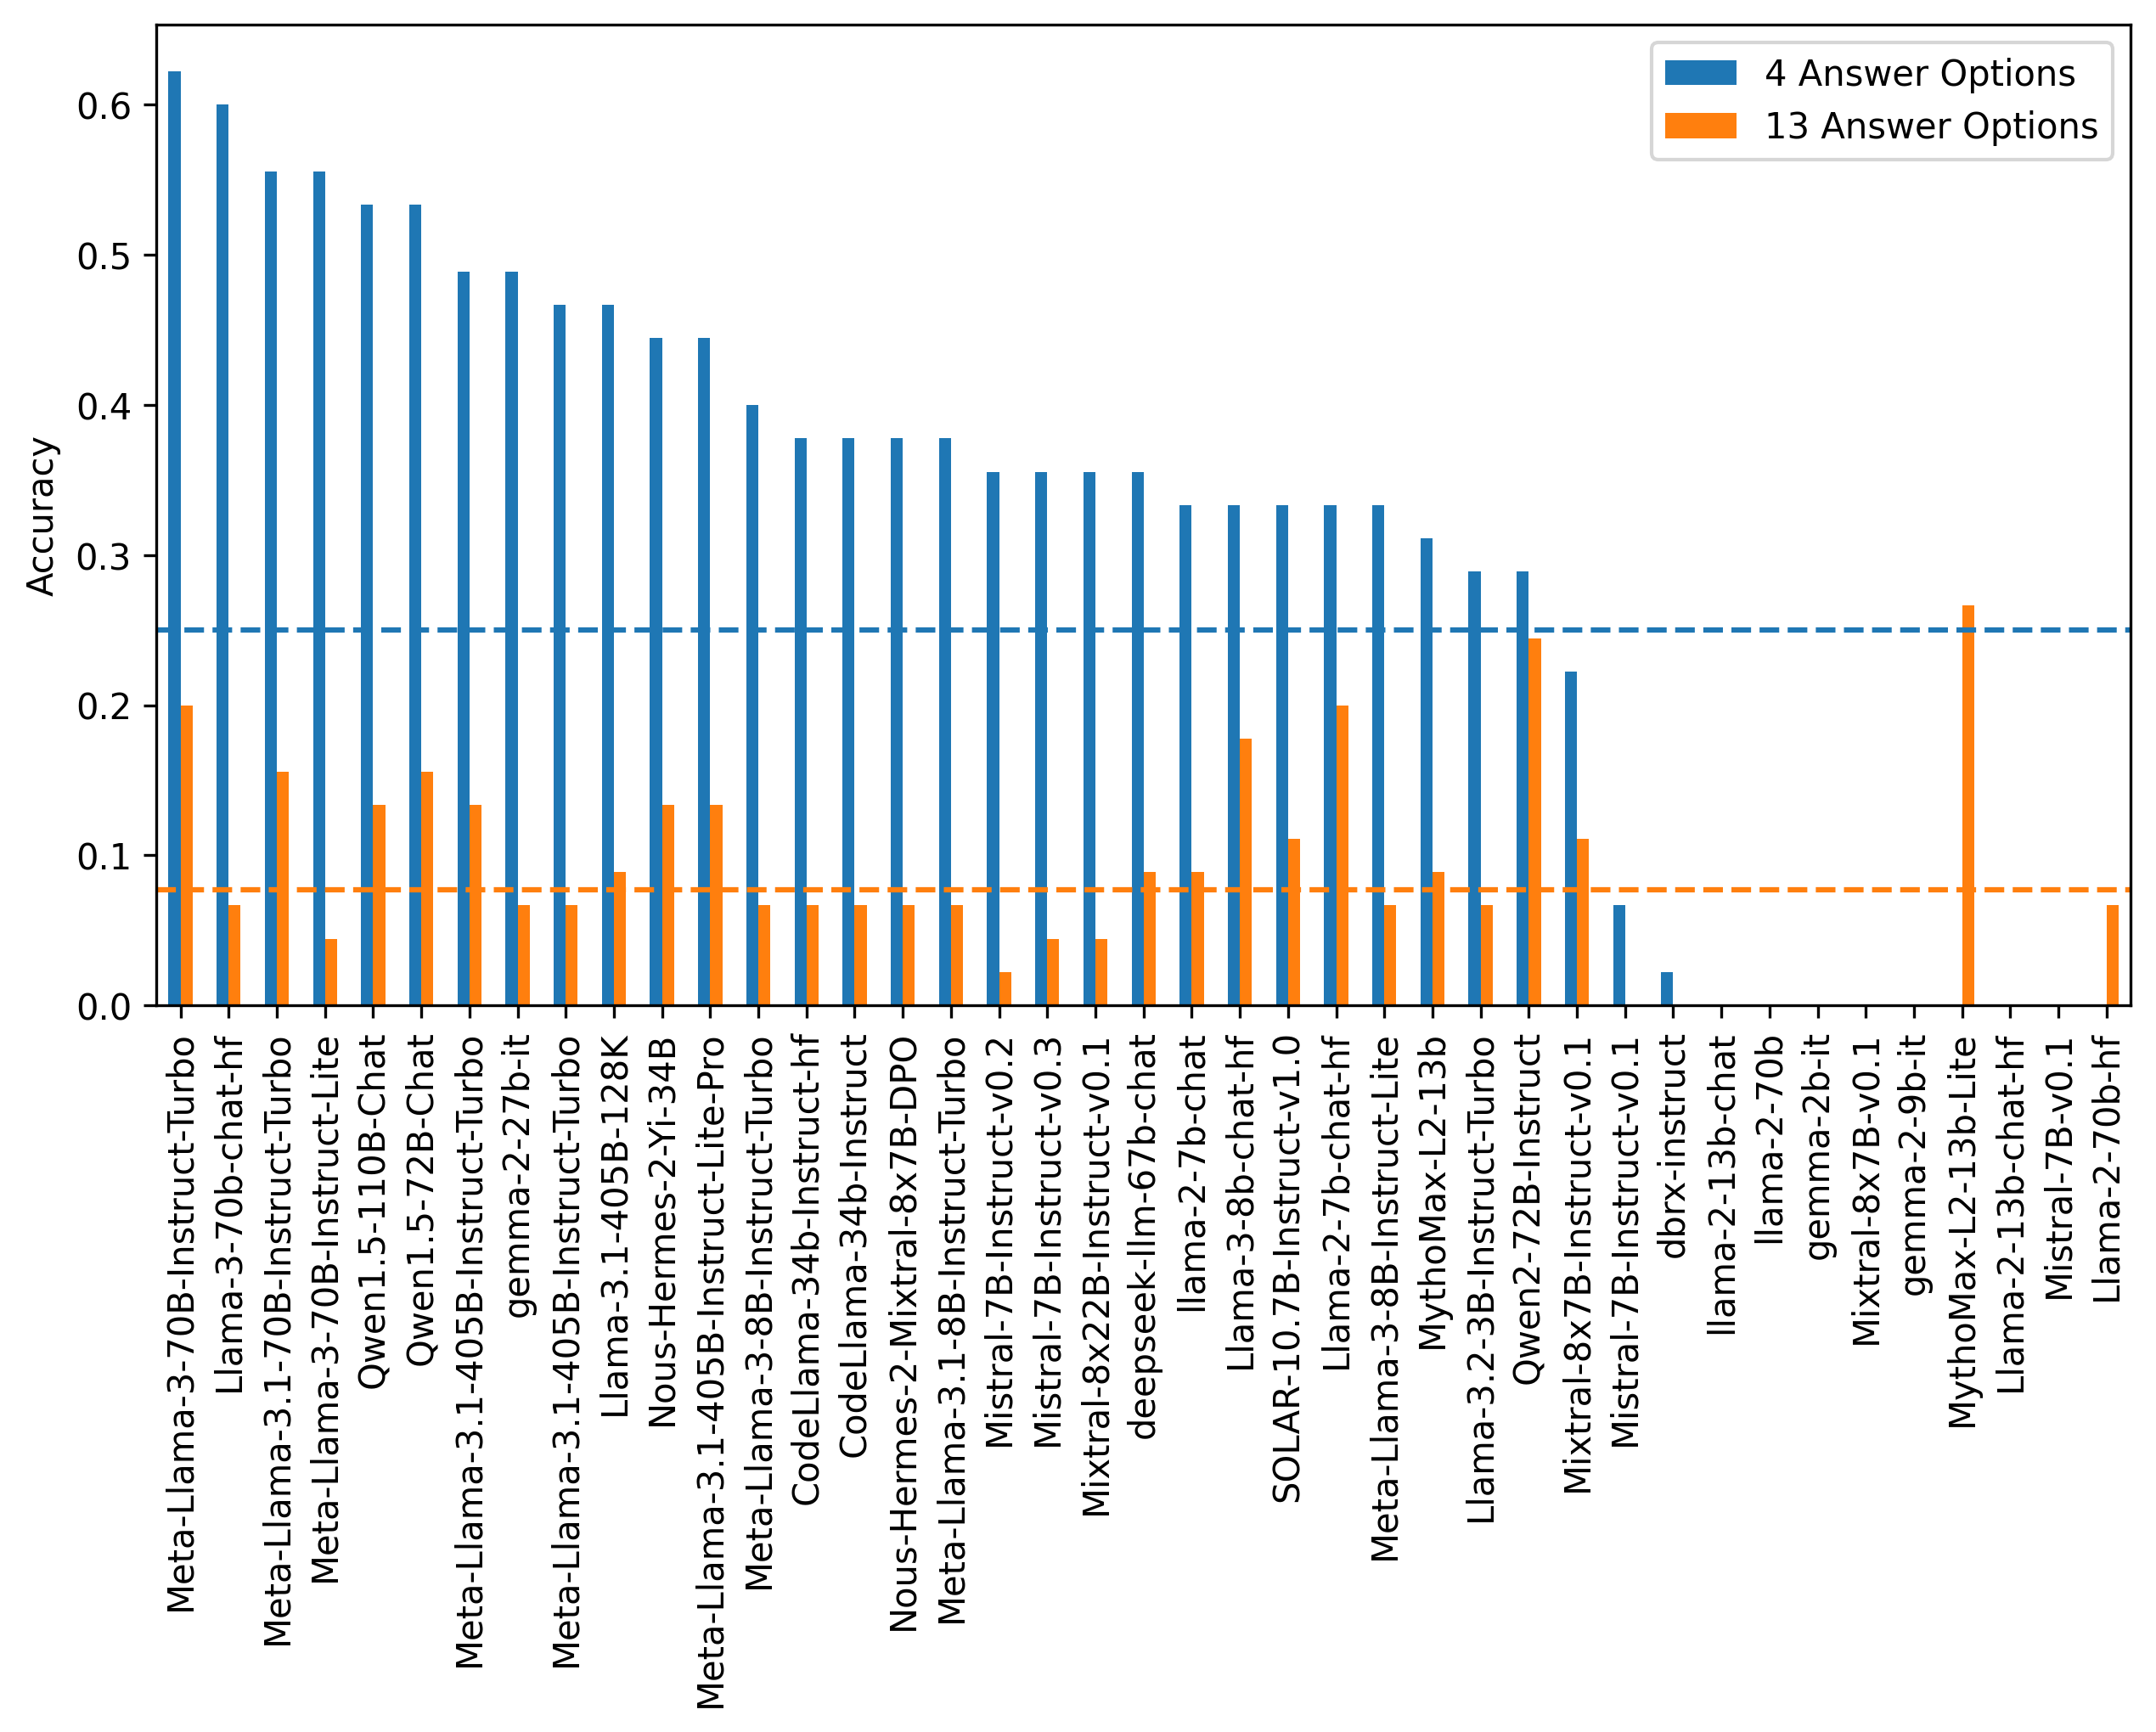

In [46]:
#bar chart with two groups
df = pd.DataFrame({
    '4 Answer Options': abcd.accuracy,
    '13 Answer Options': abcd_all.accuracy
})
df.index = abcd.models_names
df = df.sort_values(by='4 Answer Options', ascending=False)
model_names = [model.split('/')[1] for model in df.index]
df.plot(kind='bar', figsize=(10, 5))
plt.ylabel('Accuracy')
plt.axhline(y=1/4, color='tab:blue', linestyle='--')
plt.axhline(y=1/13, color='tab:orange', linestyle='--')
plt.xticks(np.arange(0, len(df), 1), model_names, rotation=90)
plt.show()

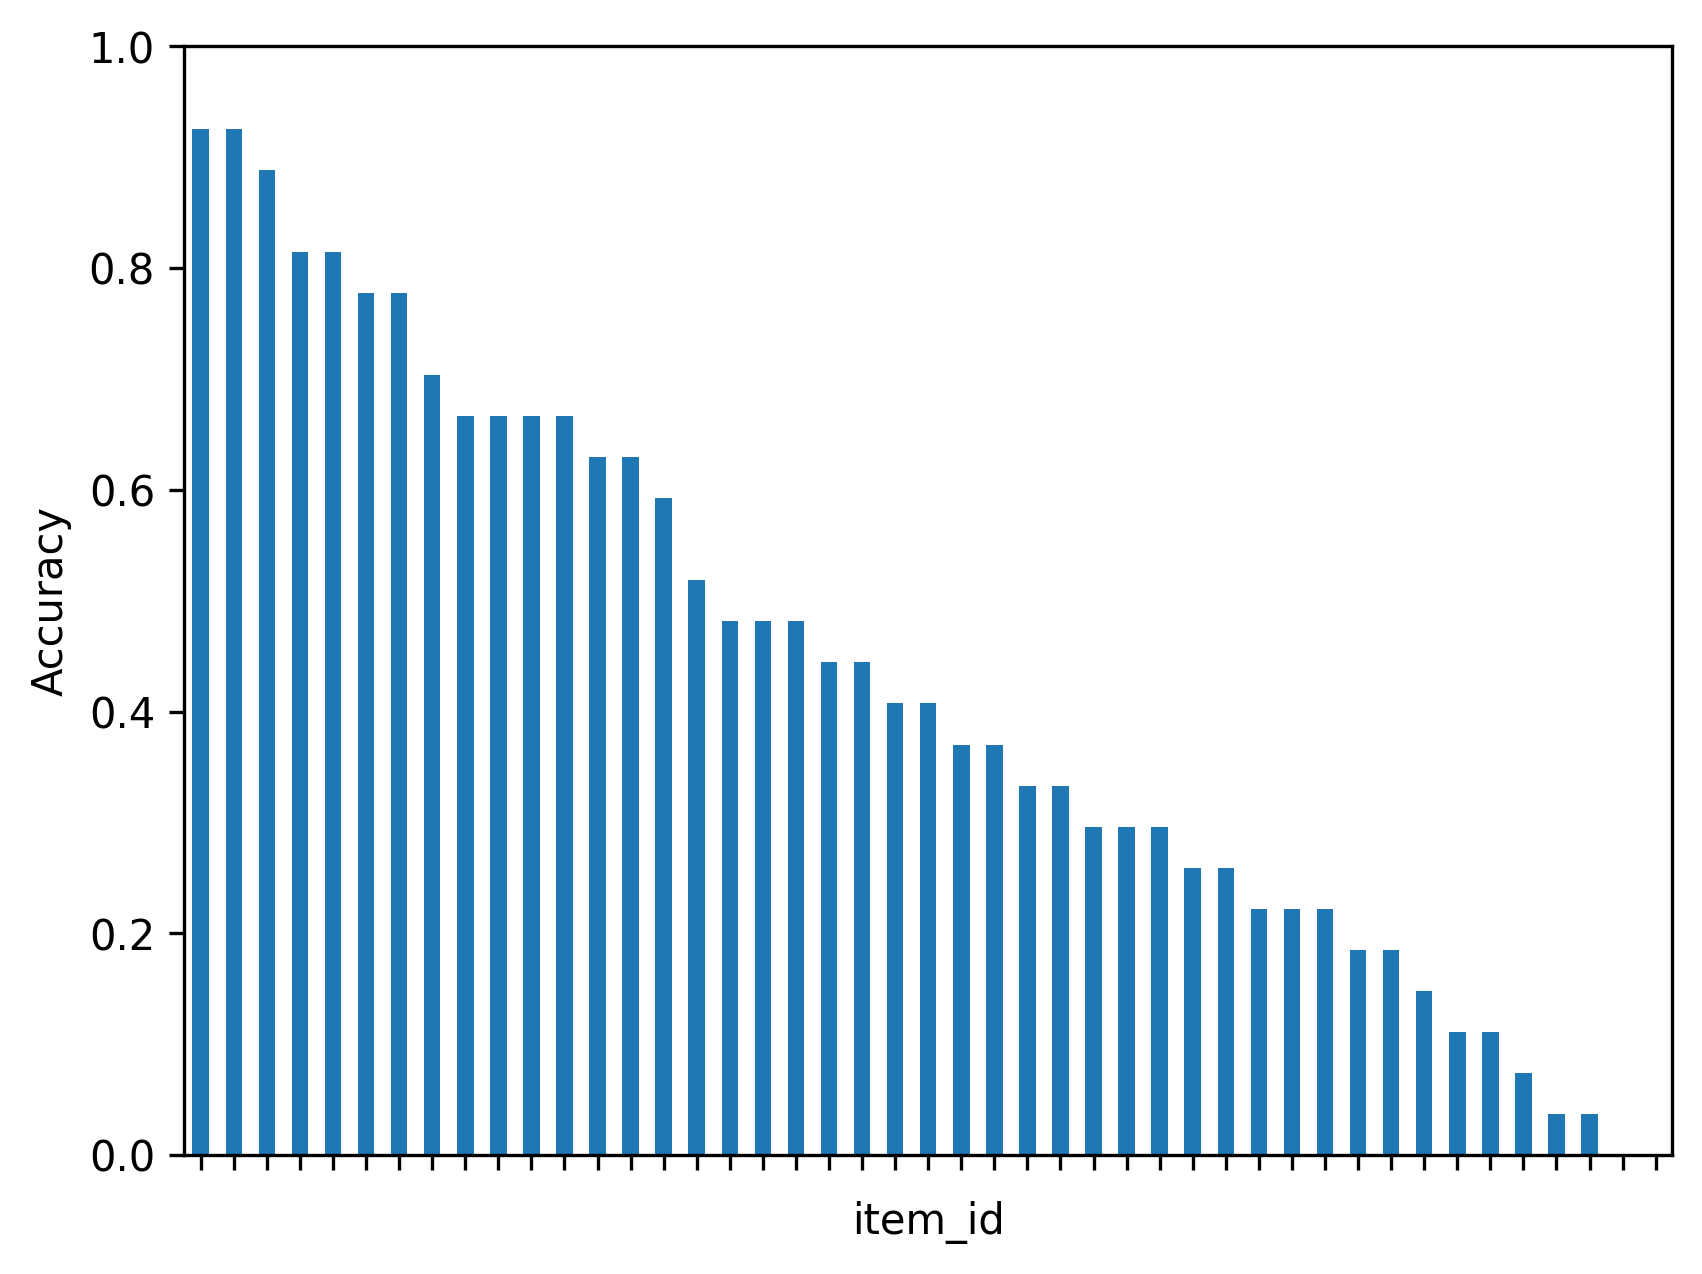

In [47]:
filtered_df = abcd.df[abcd.df['model'].isin(list(df[df['4 Answer Options'] > 0.3].index))]
filtered_df.groupby('item_id')['concept_acc'].mean().sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Accuracy')
plt.xticks(ticks=plt.gca().get_xticks(), labels=[])
plt.ylim(0, 1)
plt.show()

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_68563/2394485166.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


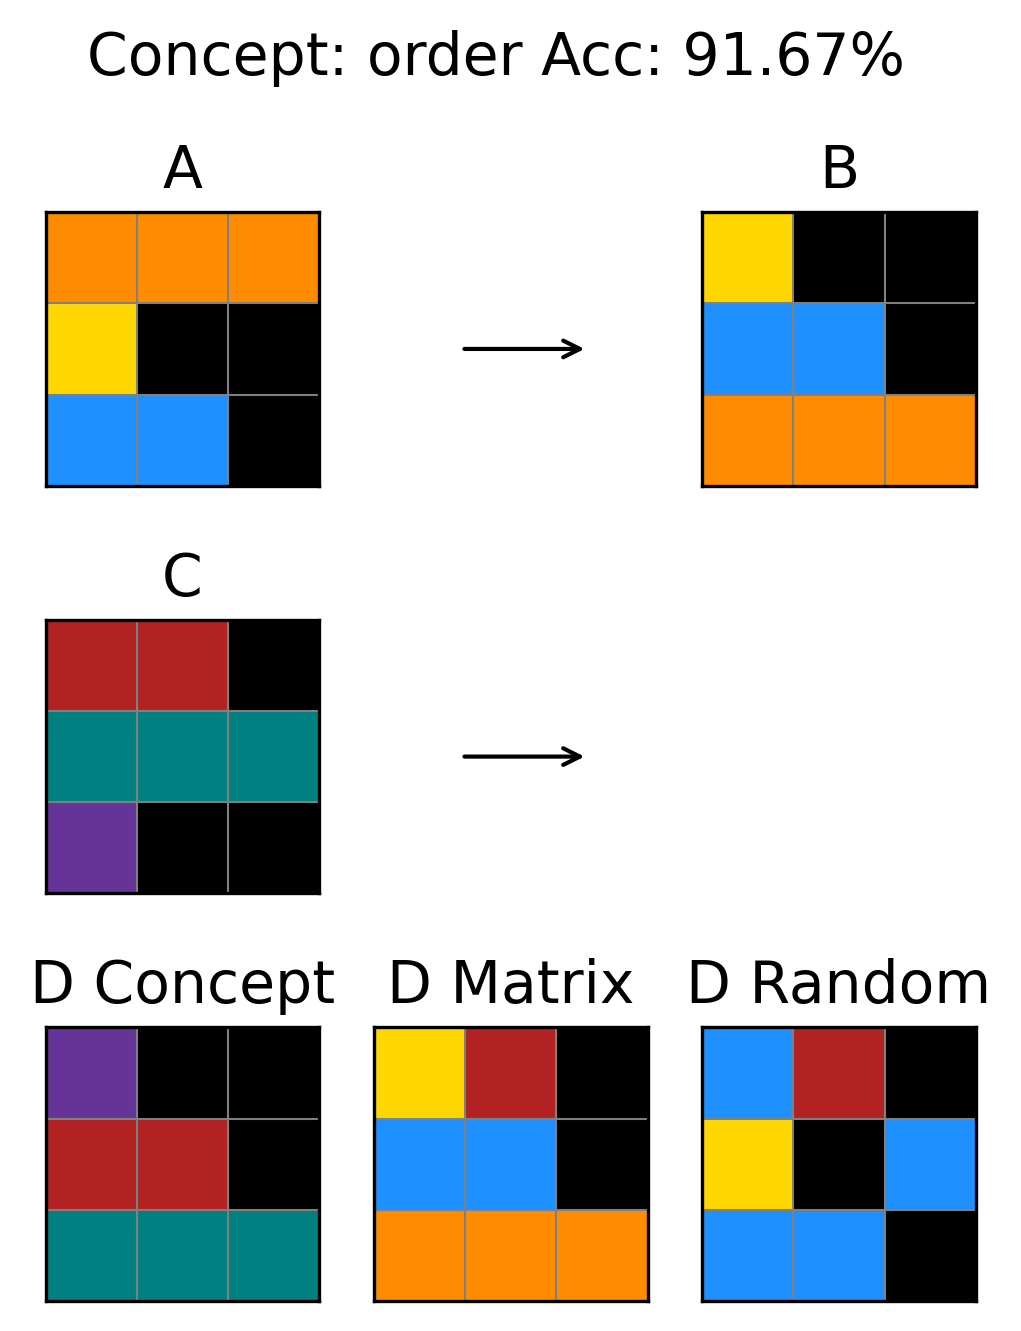

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_68563/2394485166.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


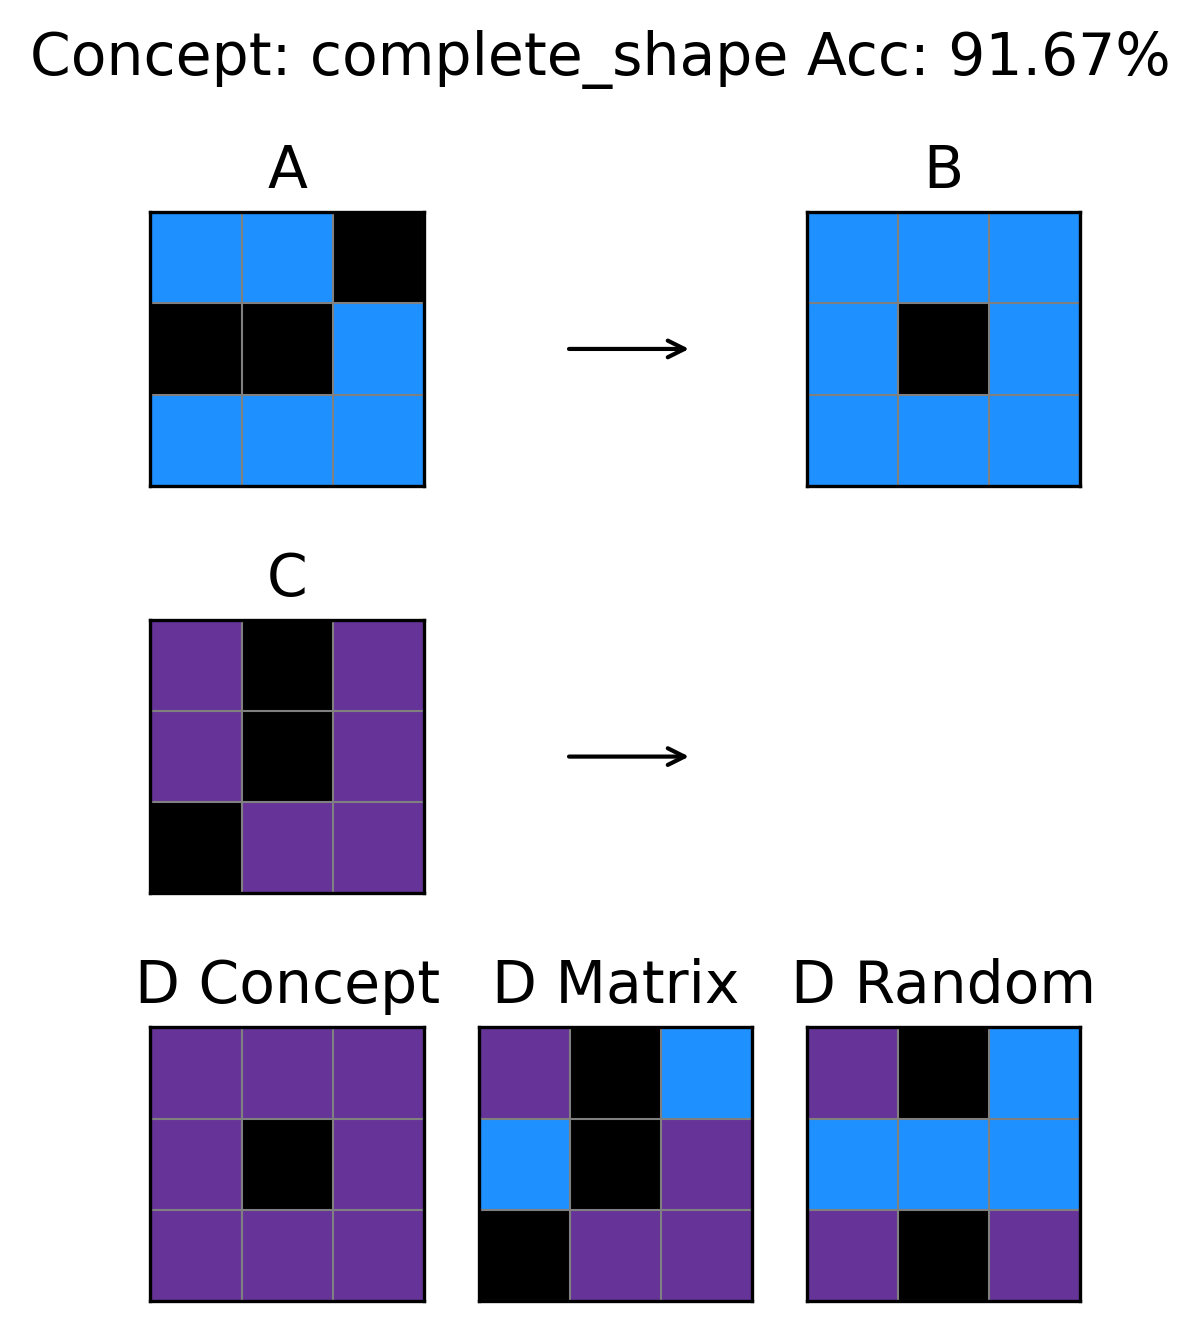

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_68563/2394485166.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


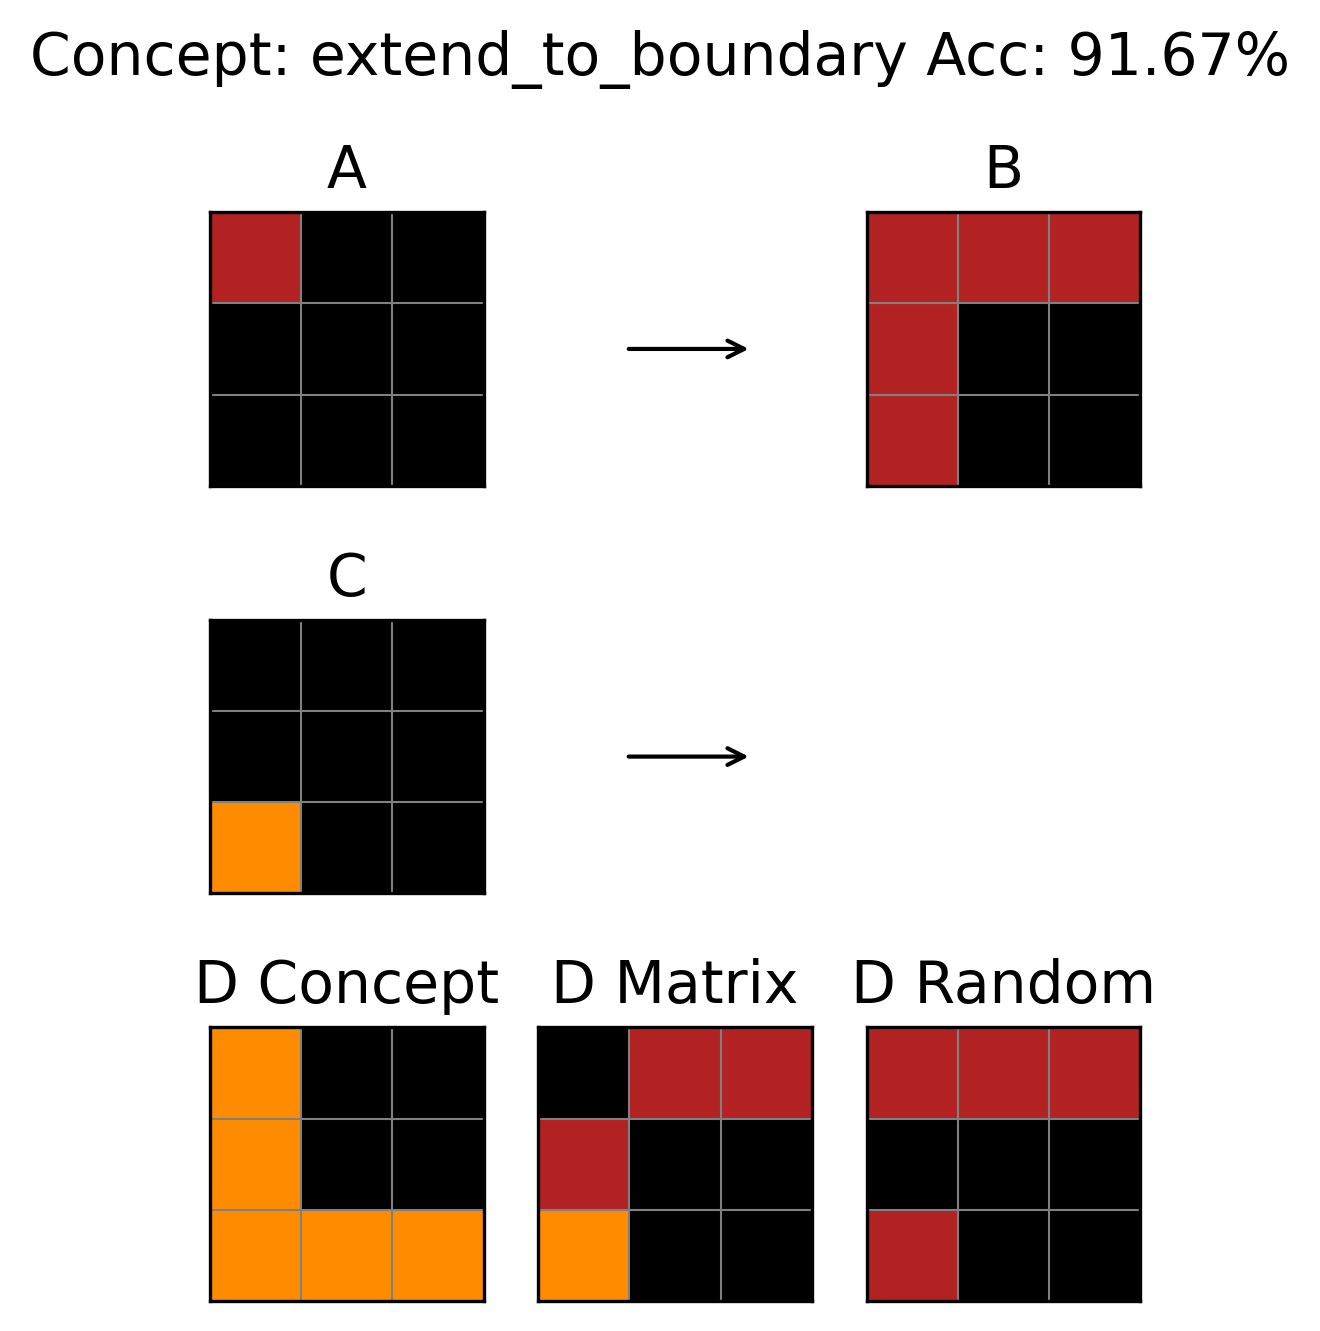

In [130]:
def plot_most_common(df, top=3, ascending=False):
    df = df.sort_values(ascending=ascending)[:top]
    for i in range(top):      
        concept = abcd.dataset.items_data[df.index[i]]['concept']
        abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')

plot_most_common(filtered_df.groupby('item_id')['concept_acc'].mean(), top=3, ascending=False)

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_68563/2394485166.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


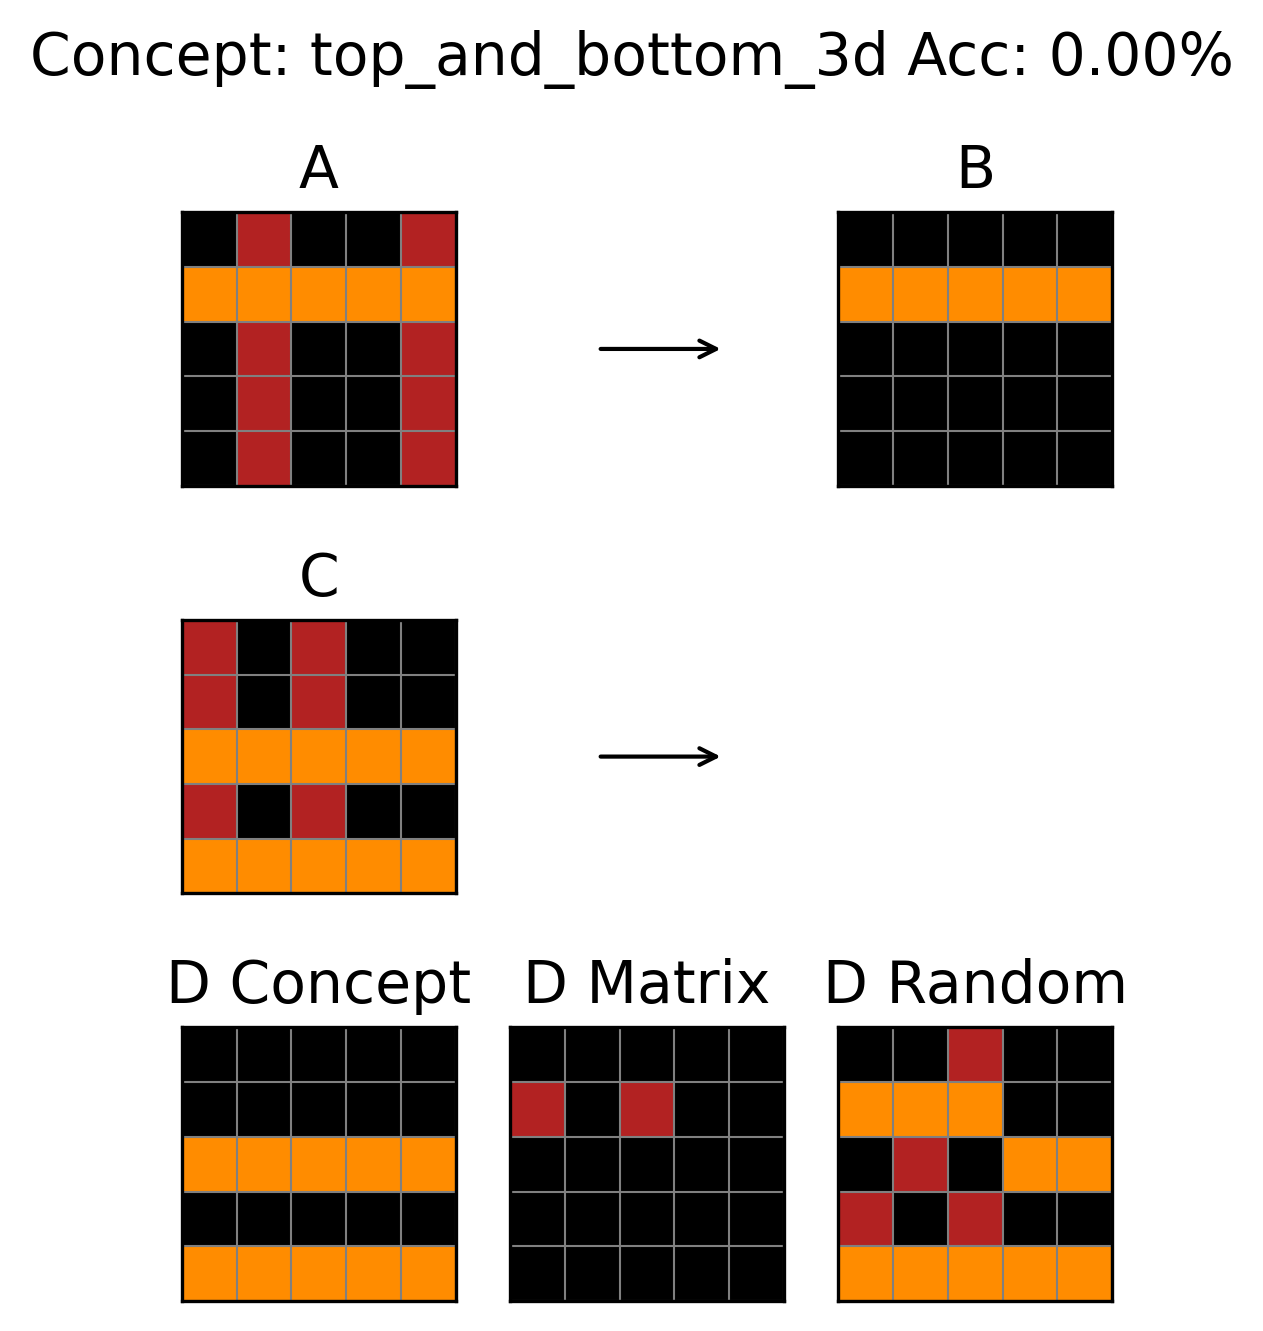

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_68563/2394485166.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


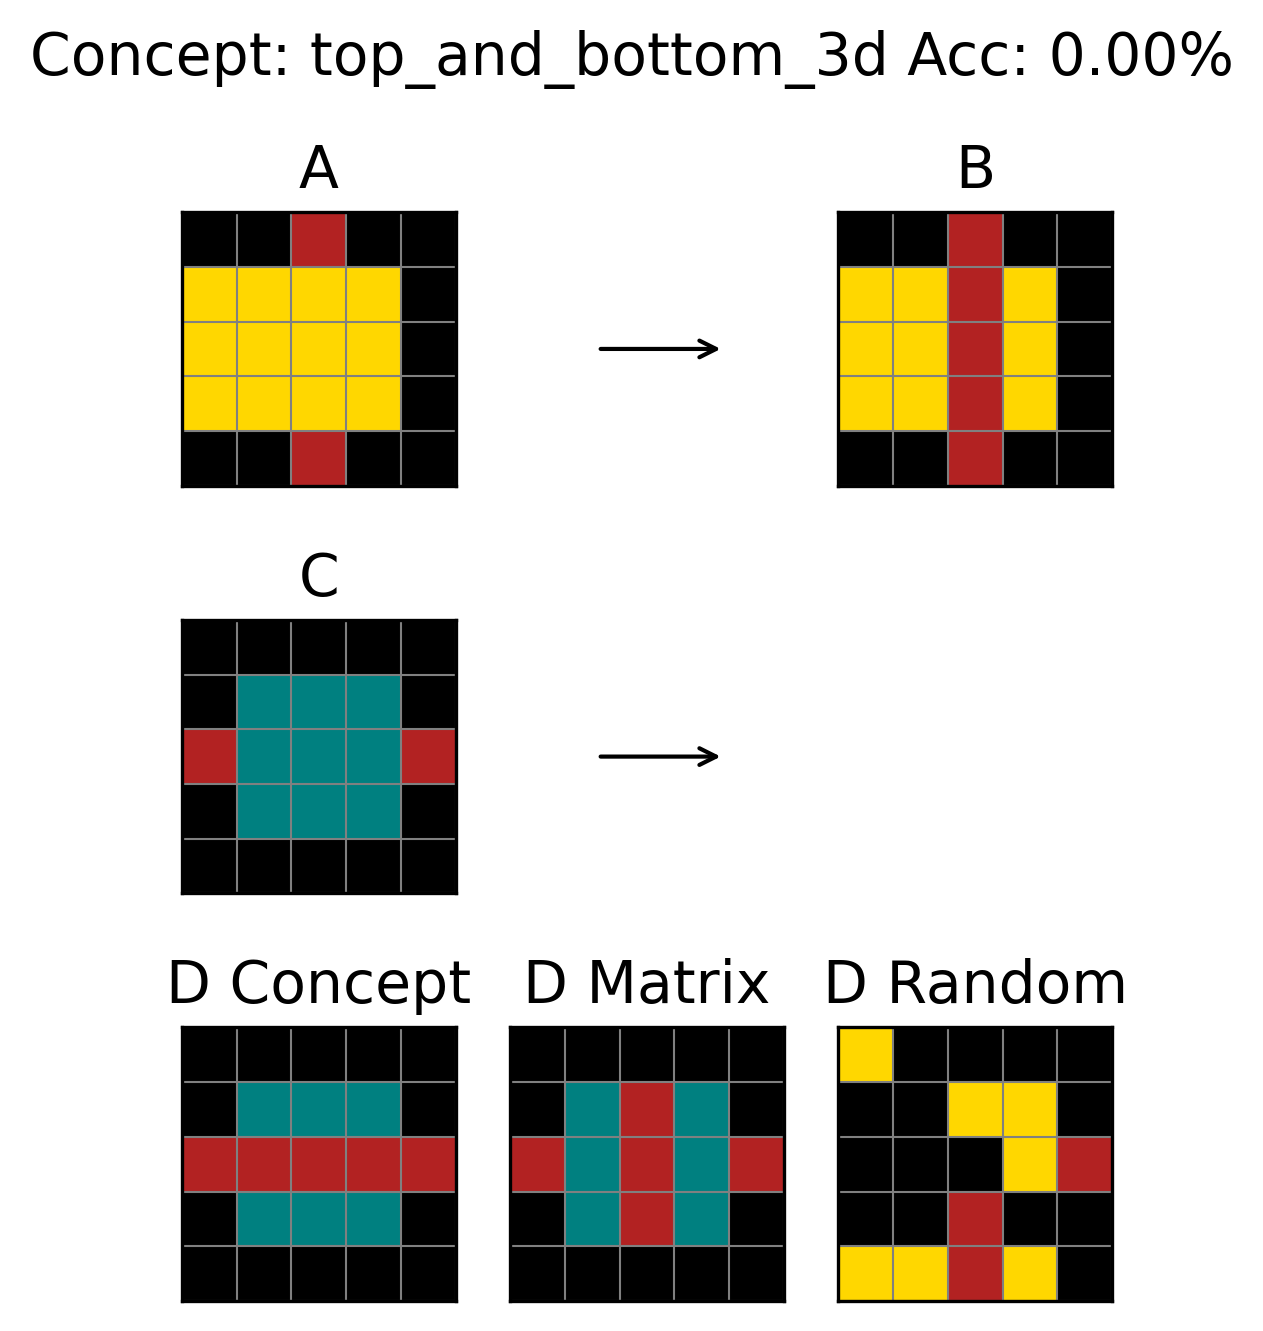

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_68563/2394485166.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  abcd.dataset.plot(df.index[i], f'Concept: {concept} Acc: {df[i] * 100:.2f}%')


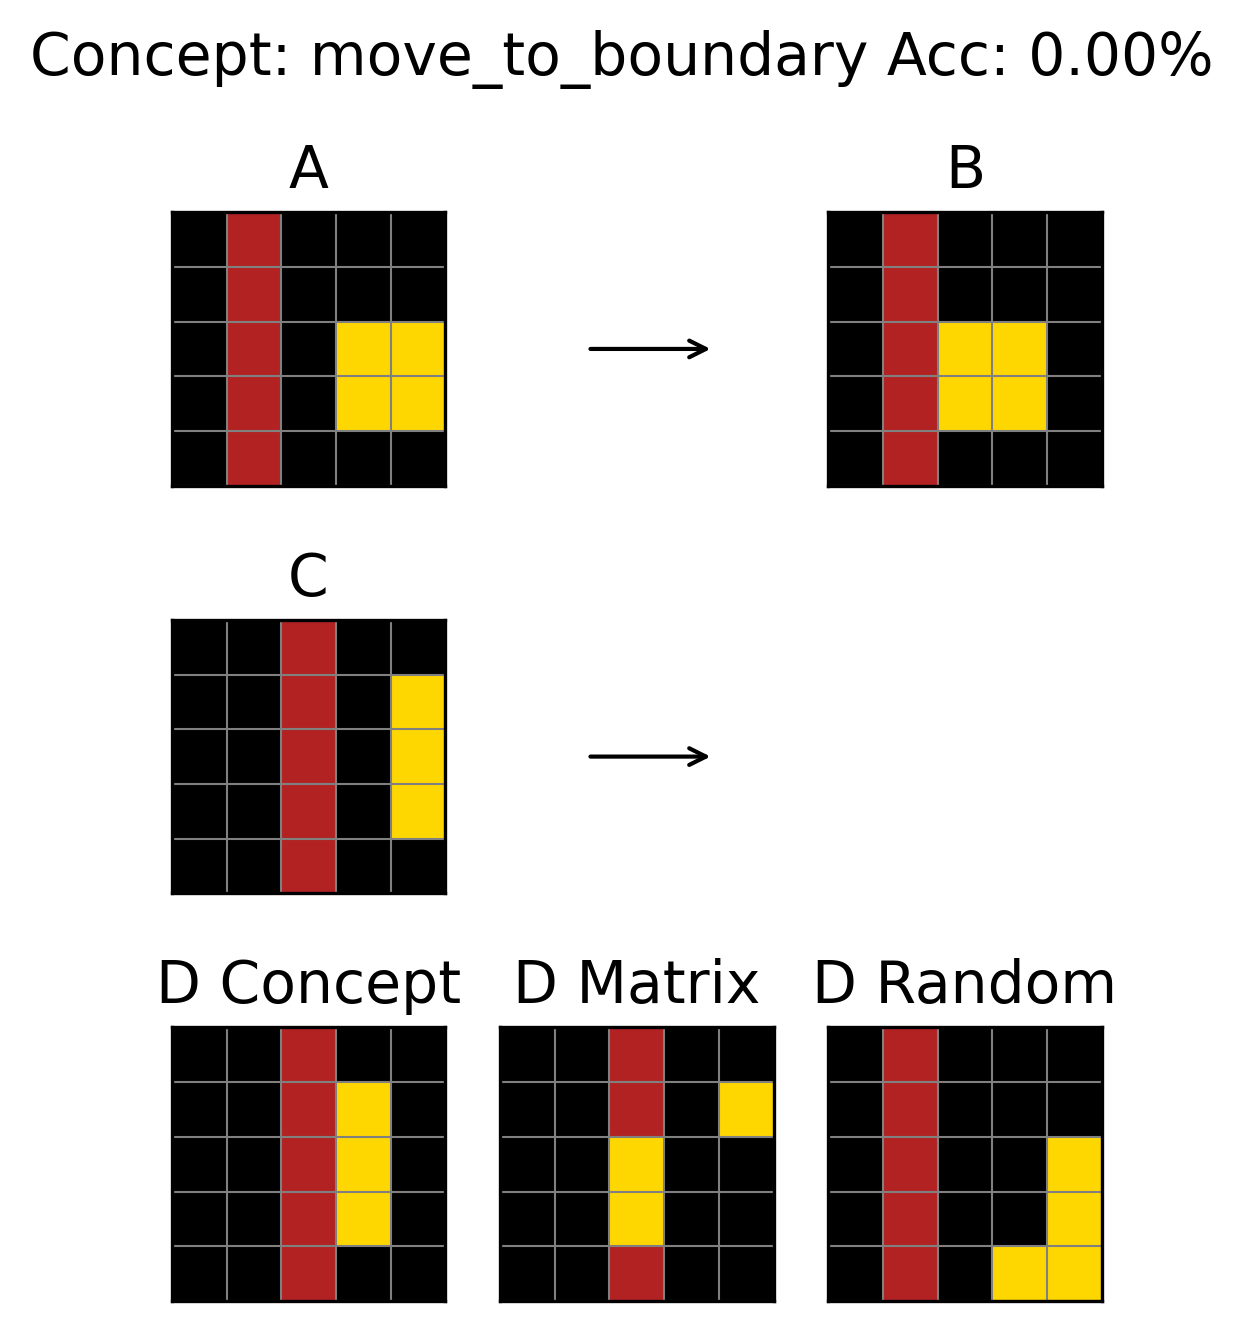

In [131]:
plot_most_common(filtered_df.groupby('item_id')['concept_acc'].mean(), top=3, ascending=True)

<Axes: ylabel='concept'>

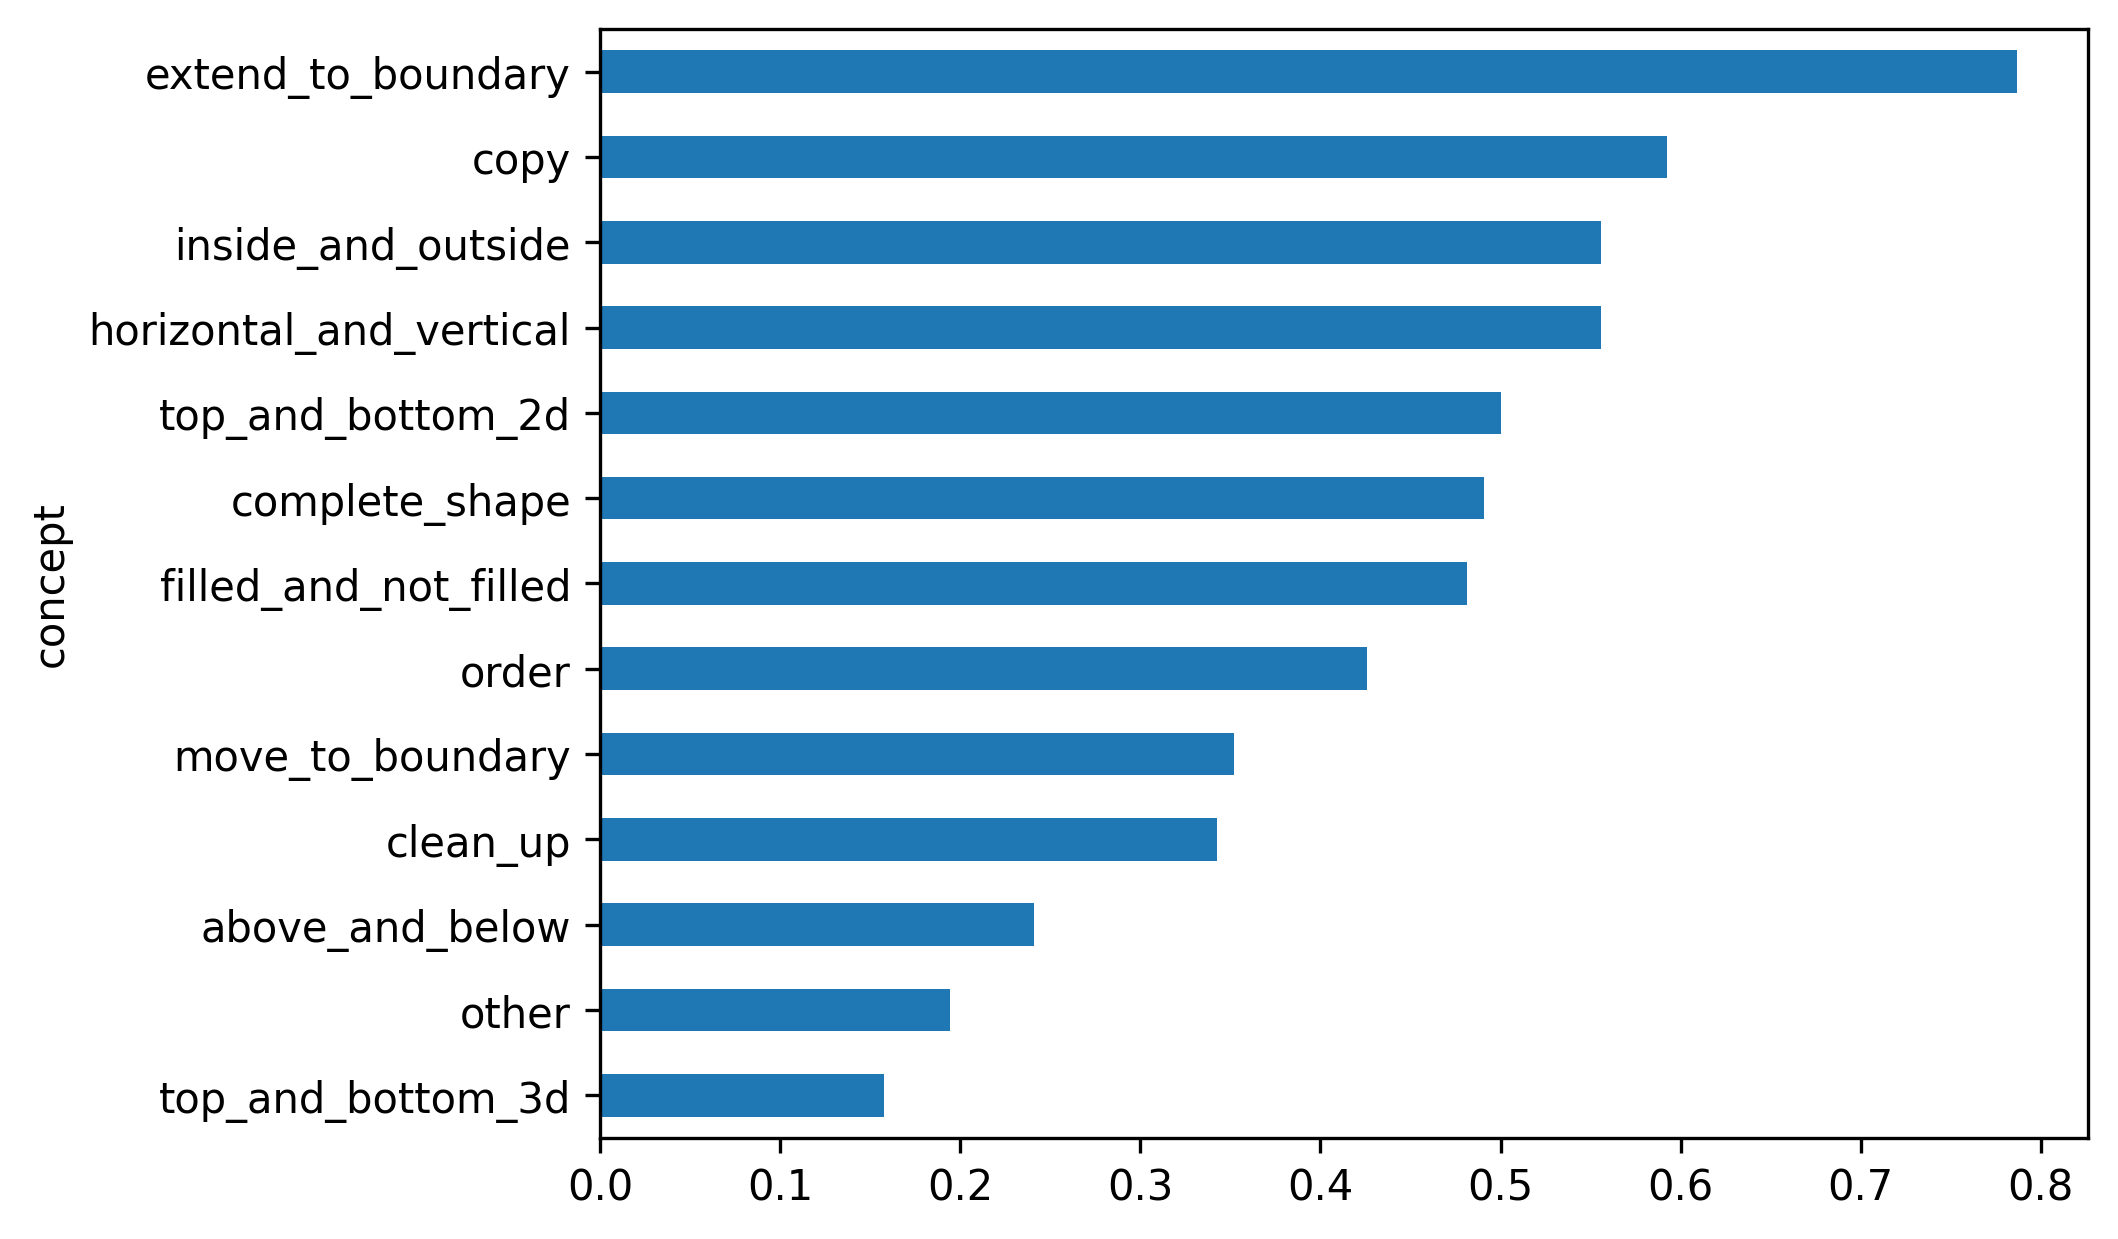

In [48]:
# horizontal
filtered_df.groupby('concept')['concept_acc'].mean().sort_values(ascending=True).plot(kind='barh')

# Open-ended

In [49]:
results_dir = 'data/results'
data_oe = json.load(open(f'{results_dir}/open_ended.json', 'r'))
dataset_oe = AmbigousARCDataset(items, 
    task='generation', 
    seed=42
)
oe = Eval(data_oe, dataset=dataset_oe, prop_test_thresh=None)
oe.print()

Number of models: 36
Concept: 0.15
Matrix: 0.02

Total excluded models: 4/40 (10%)
4/40 (10%) models excluded due to high no response rate.

In [50]:
abcd_filtered = Eval('data/results/concept_task_3.json')
abcd_filtered.print()

Number of models: 15
Accuracy: 0.42

Total excluded models: 26/41 (63%)
11/41 (27%) models excluded due to high no response rate.
15/41 (37%) models excluded due to biased answer choices.

In [87]:
all_models = [mc_random.df['model'].unique(), abcd.df['model'].unique(), oe.df['model'].unique()]
models_filtered = set.intersection(*[set(models) for models in all_models])

mc_filtered = mc_random.df[mc_random.df['model'].isin(models_filtered)].reset_index(drop=True)
abcd_filtered = abcd.df[abcd.df['model'].isin(models_filtered)].reset_index(drop=True)
oe_filtered = oe.df[oe.df['model'].isin(models_filtered)].reset_index(drop=True)

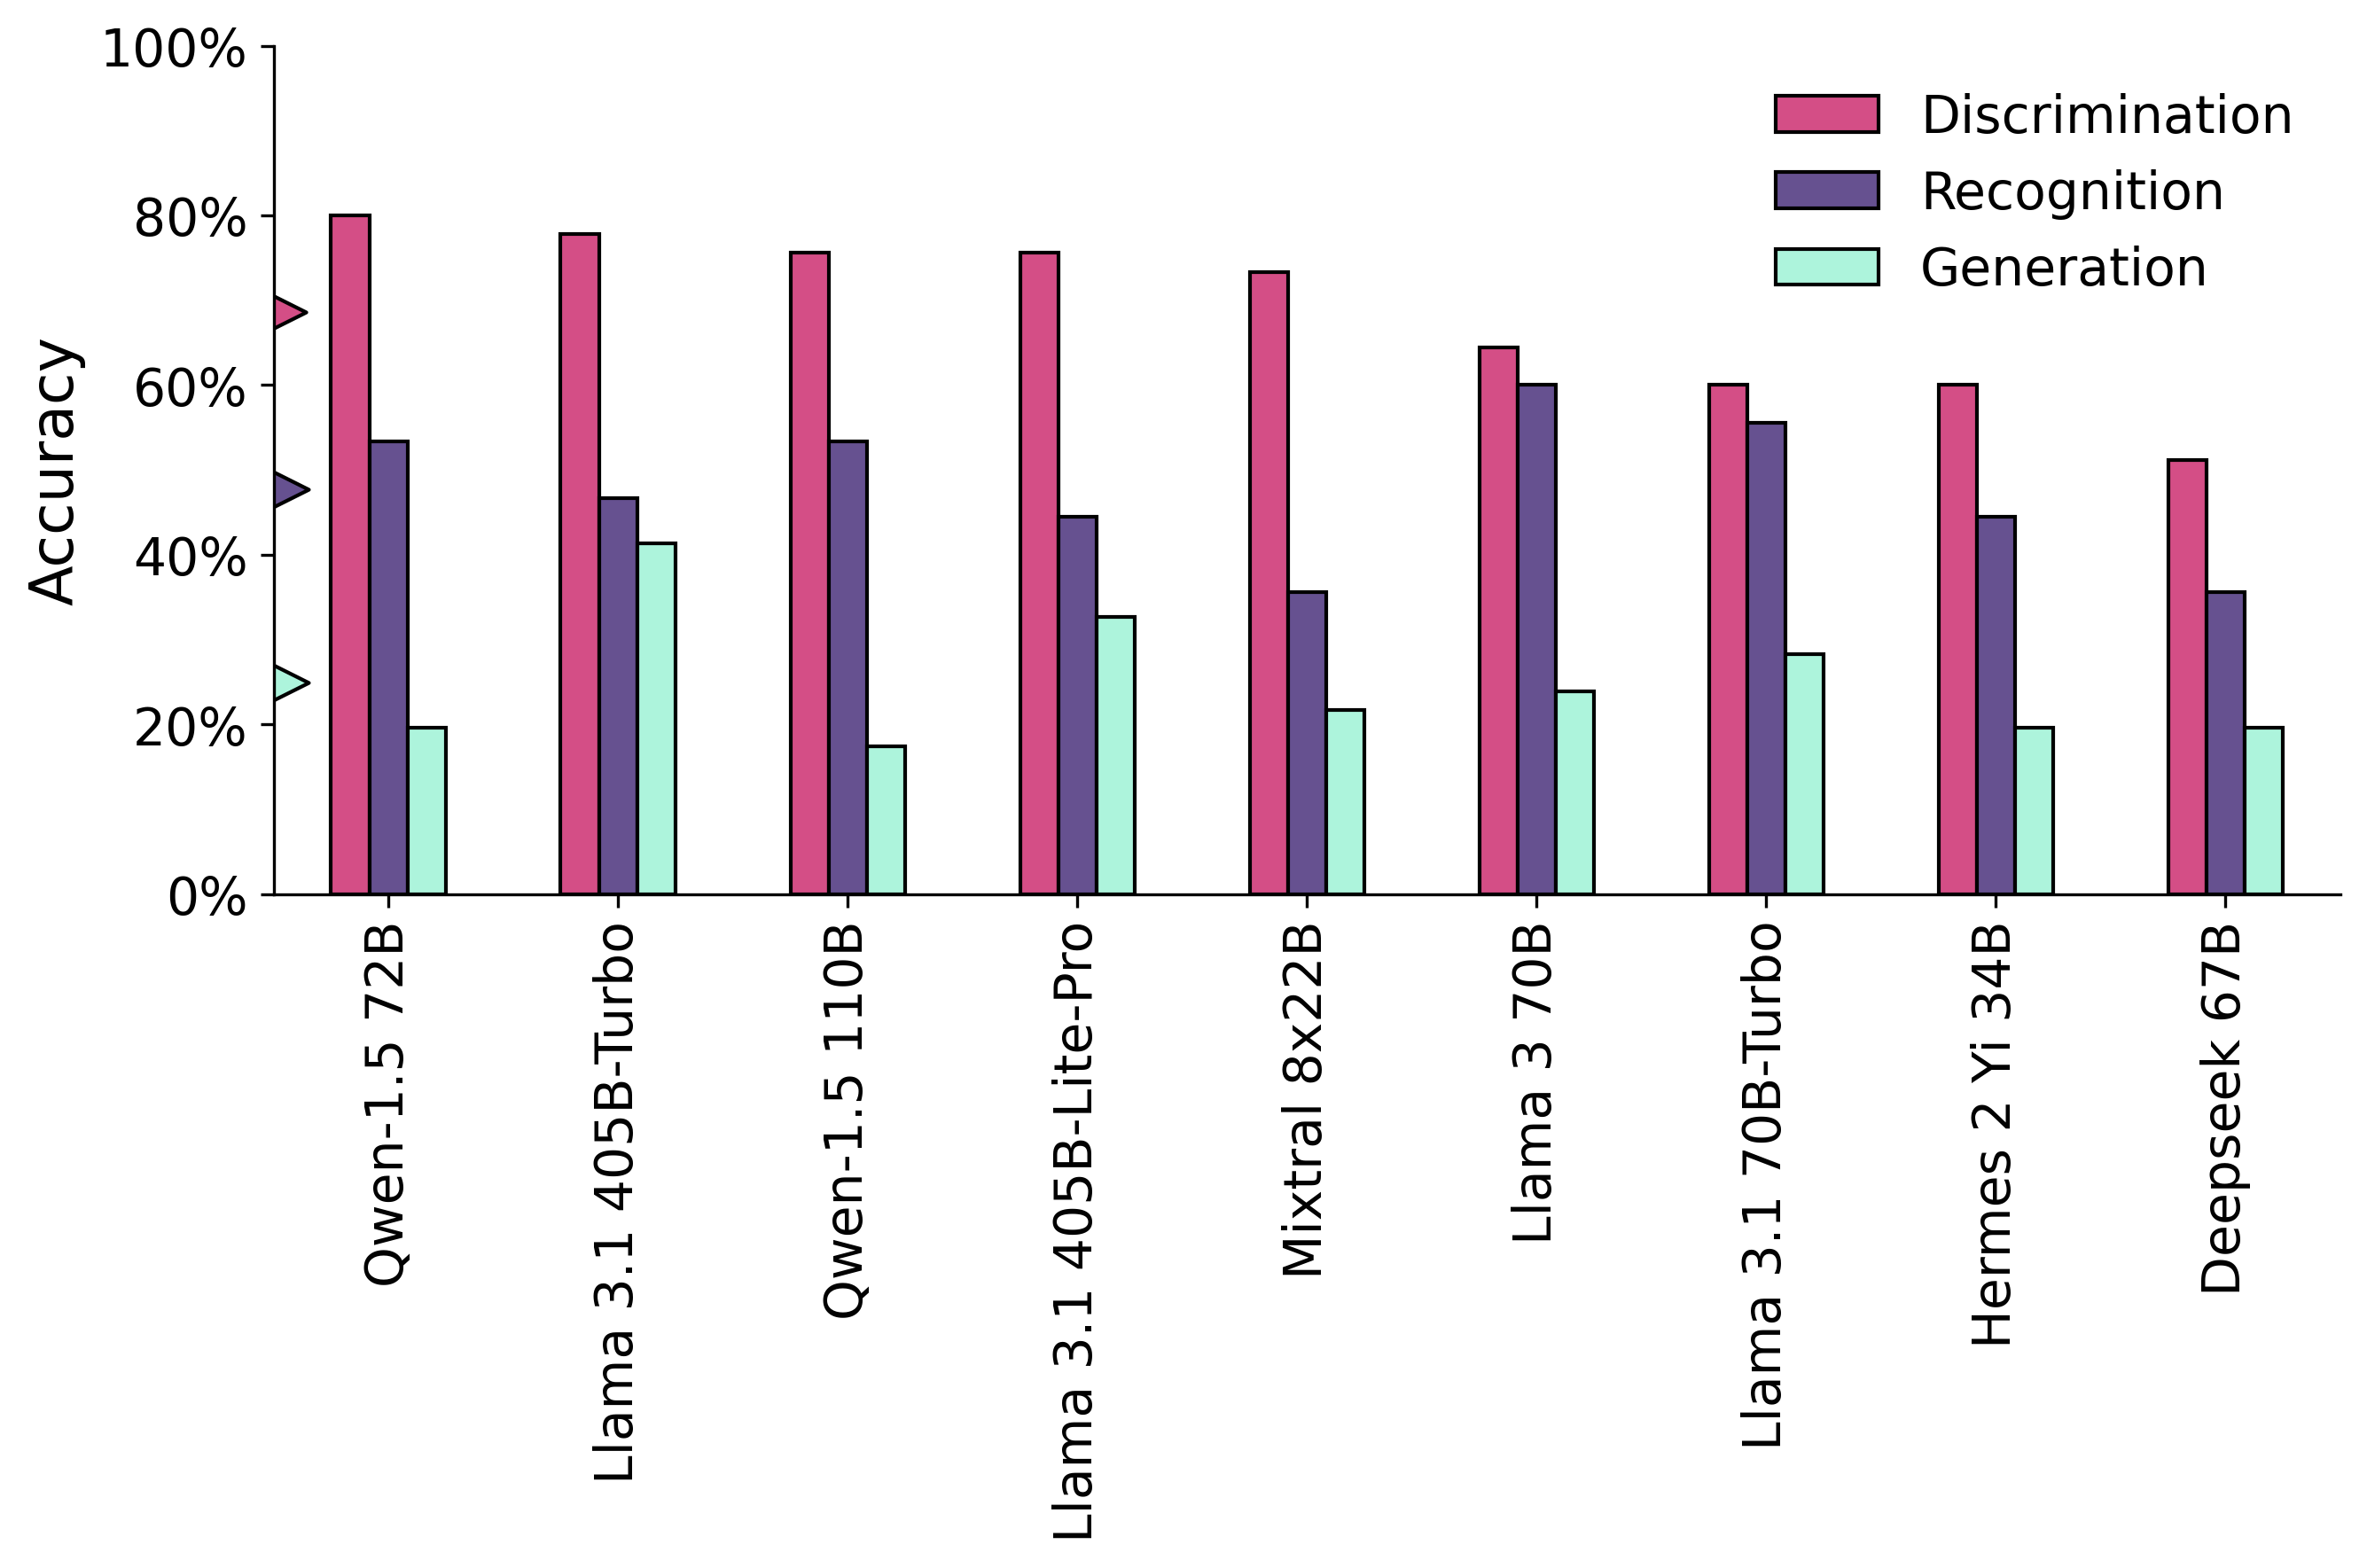

In [88]:
names = {
    'Hermes-3-Llama-3.1-405B-Turbo': 'Hermes 3.1 405B-Turbo',
    'Qwen1.5-72B-Chat': 'Qwen-1.5 72B',
    'Meta-Llama-3.1-405B-Instruct-Turbo': 'Llama 3.1 405B-Turbo',
    'Qwen1.5-110B-Chat': 'Qwen-1.5 110B',
    'Meta-Llama-3.1-405B-Instruct-Lite-Pro': 'Llama 3.1 405B-Lite-Pro',
    'Mixtral-8x22B-Instruct-v0.1': 'Mixtral 8x22B',
    'Llama-3-70b-chat-hf': 'Llama 3 70B',
    'Nous-Hermes-2-Yi-34B': 'Hermes 2 Yi 34B',
    'Meta-Llama-3.1-70B-Instruct-Turbo': 'Llama 3.1 70B-Turbo',
    'deepseek-llm-67b-chat': 'Deepseek 67B',
}

# DataFrame creation
df = pd.DataFrame({
    'Discrimination': mc_filtered.groupby('model')['concept_response'].mean(),
    'Recognition': abcd_filtered.groupby('model')['concept_acc'].mean(),
    'Generation': oe_filtered.groupby('model')['concept_response'].mean(),
})

# Sort the DataFrame
df = df.sort_values(by=['Discrimination', 'Recognition'], ascending=False)

# Model names adjustment
model_names = [model.split('/')[1] for model in df.index]
model_names = [names.get(name, name) for name in model_names]

# Plotting
ax = df.plot(kind='bar', figsize=(9, 6), color=['#d44e86', '#665190', '#adf4dc'], edgecolor='black')

# Set axis labels and ticks
plt.ylabel('Accuracy', size=16)
plt.xticks(np.arange(0, len(df), 1), model_names, rotation=90, size=14)
plt.yticks(np.linspace(0, 1, num=6), [f'{x:.0%}' for x in np.linspace(0, 1, num=6)], size=14)
plt.xlabel('')
plt.ylim(0, 1)

# Calculate overall means
mean_discrimination = df['Discrimination'].mean()
mean_recognition = df['Recognition'].mean()
mean_generation = df['Generation'].mean()

# Overlay circles on the y-axis for the overall means
plt.scatter(-0.5, mean_discrimination, color='#d44e86', s=300, zorder=0, edgecolor='black', marker='>')
plt.scatter(-0.5, mean_recognition, color='#665190', s=350, zorder=0, edgecolor='black', marker='>')
plt.scatter(-0.5, mean_generation, color='#adf4dc', s=350, zorder=0, edgecolor='black', marker='>')

# Customize the legend
plt.legend(fontsize=14, edgecolor='none')

# Remove unnecessary spines
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

#plt.axhline(y=1/4, color='grey', linestyle='--', linewidth=1, zorder=0)

# Show the plot
plt.tight_layout()
plt.show()

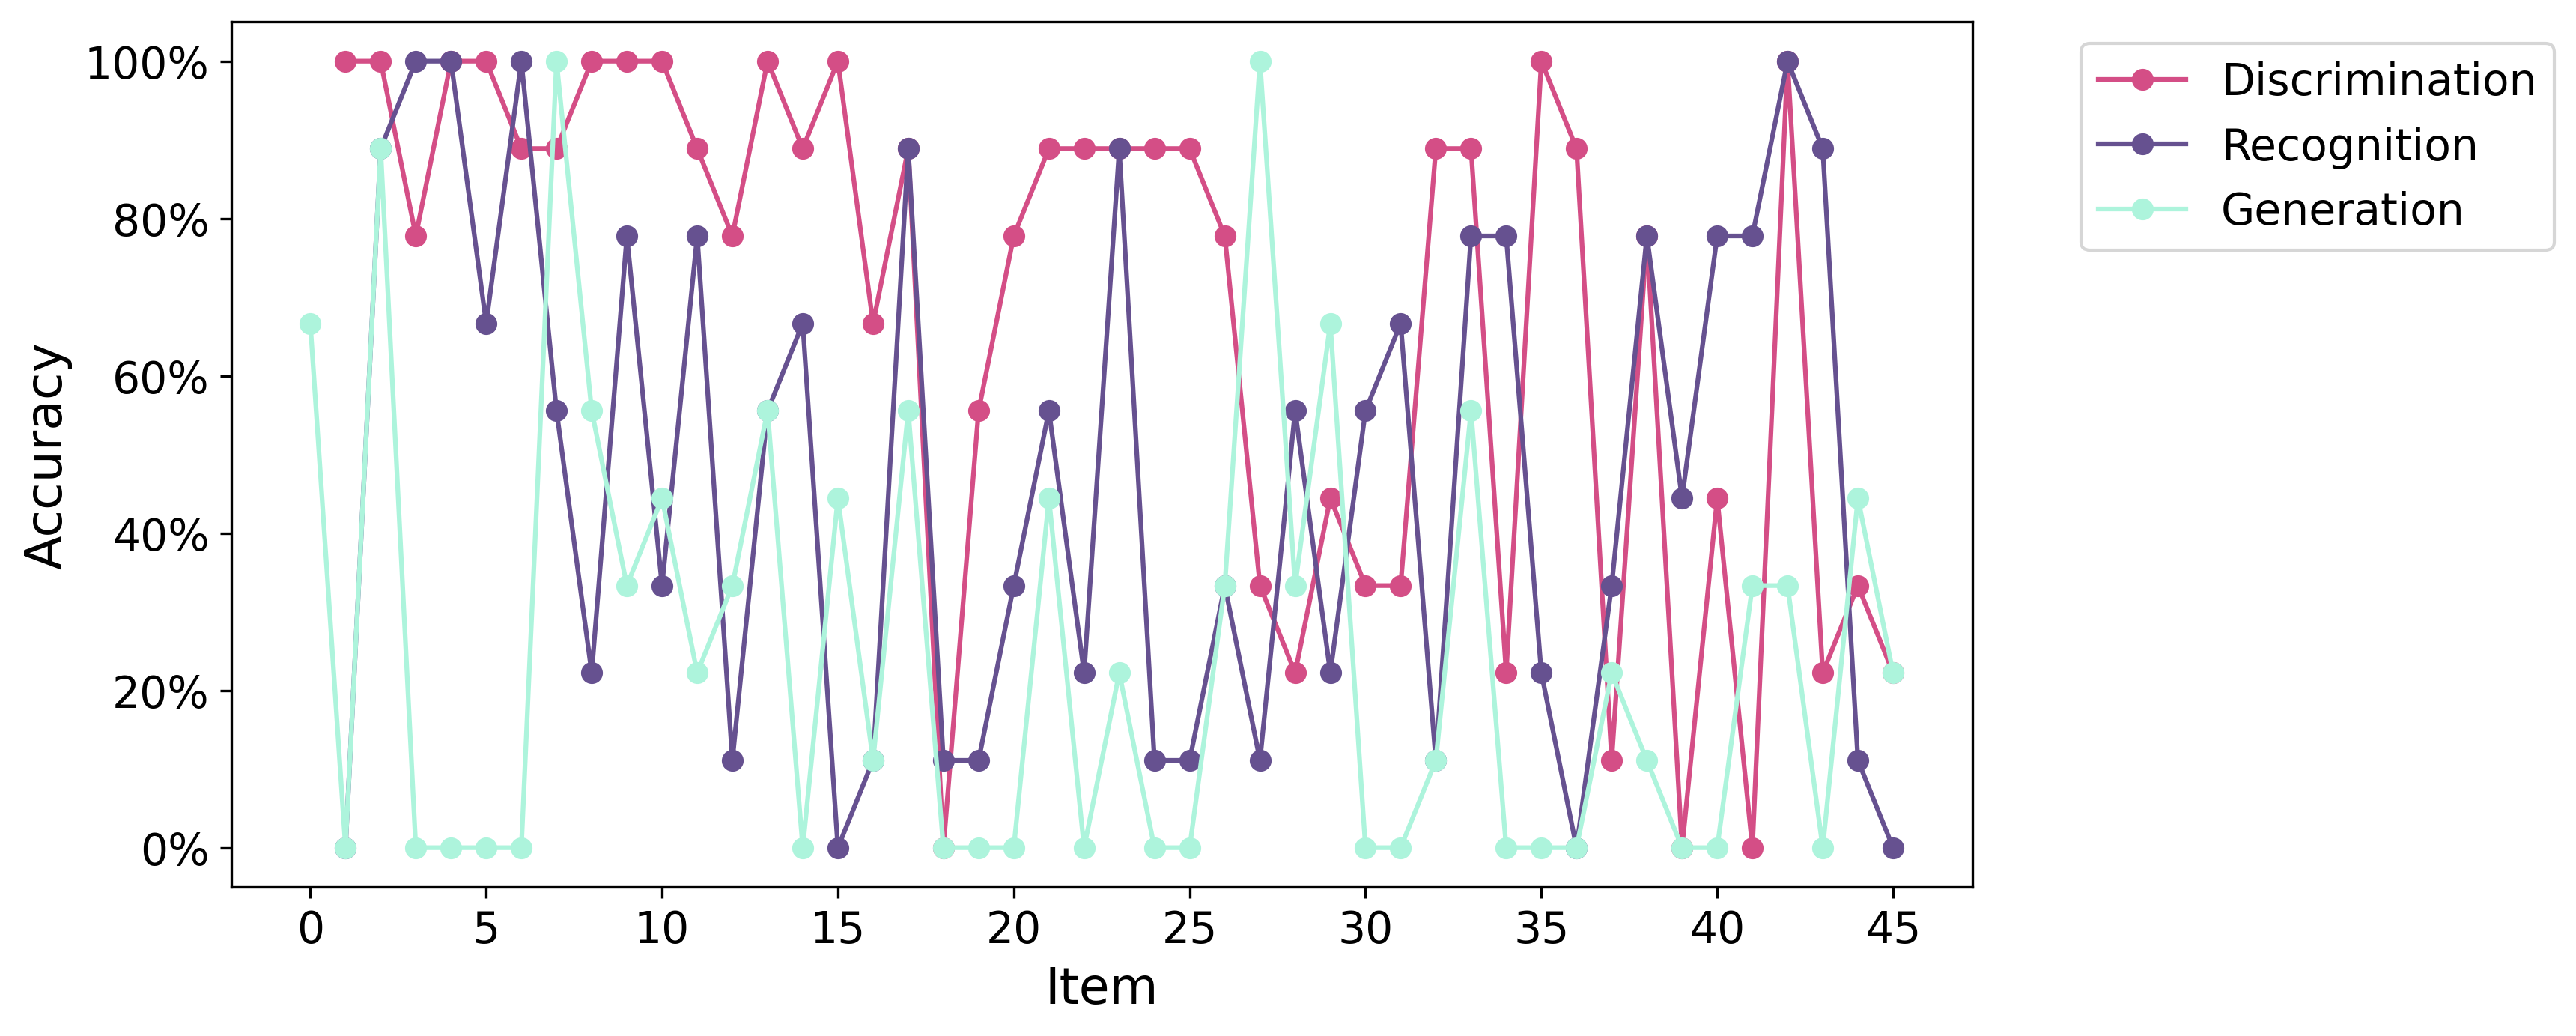

In [57]:
df_item_concept = pd.DataFrame({
    'Discrimination': mc_filtered.groupby('item_id')['concept_response'].mean(),
    'Recognition': abcd_filtered.groupby('item_id')['concept_acc'].mean(),
    'Generation': oe_filtered.groupby('item_id')['concept_response'].mean()
})
#df_item_concept = df_item_concept.sort_values(by='Multiple Choice', ascending=False)
# line plot
df_item_concept.plot(figsize=(10, 5), color=['#d44e86', '#665190', '#adf4dc'], marker='o')
plt.ylabel('Accuracy', size=16)
plt.xlabel('Item', size=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.yticks(np.linspace(0, 1, num=6), [f'{x:.0%}' for x in np.linspace(0, 1, num=6)], size=14)
plt.xticks(np.arange(0, len(df_item_concept), 5), np.arange(0, len(df_item_concept), 5))
plt.show()


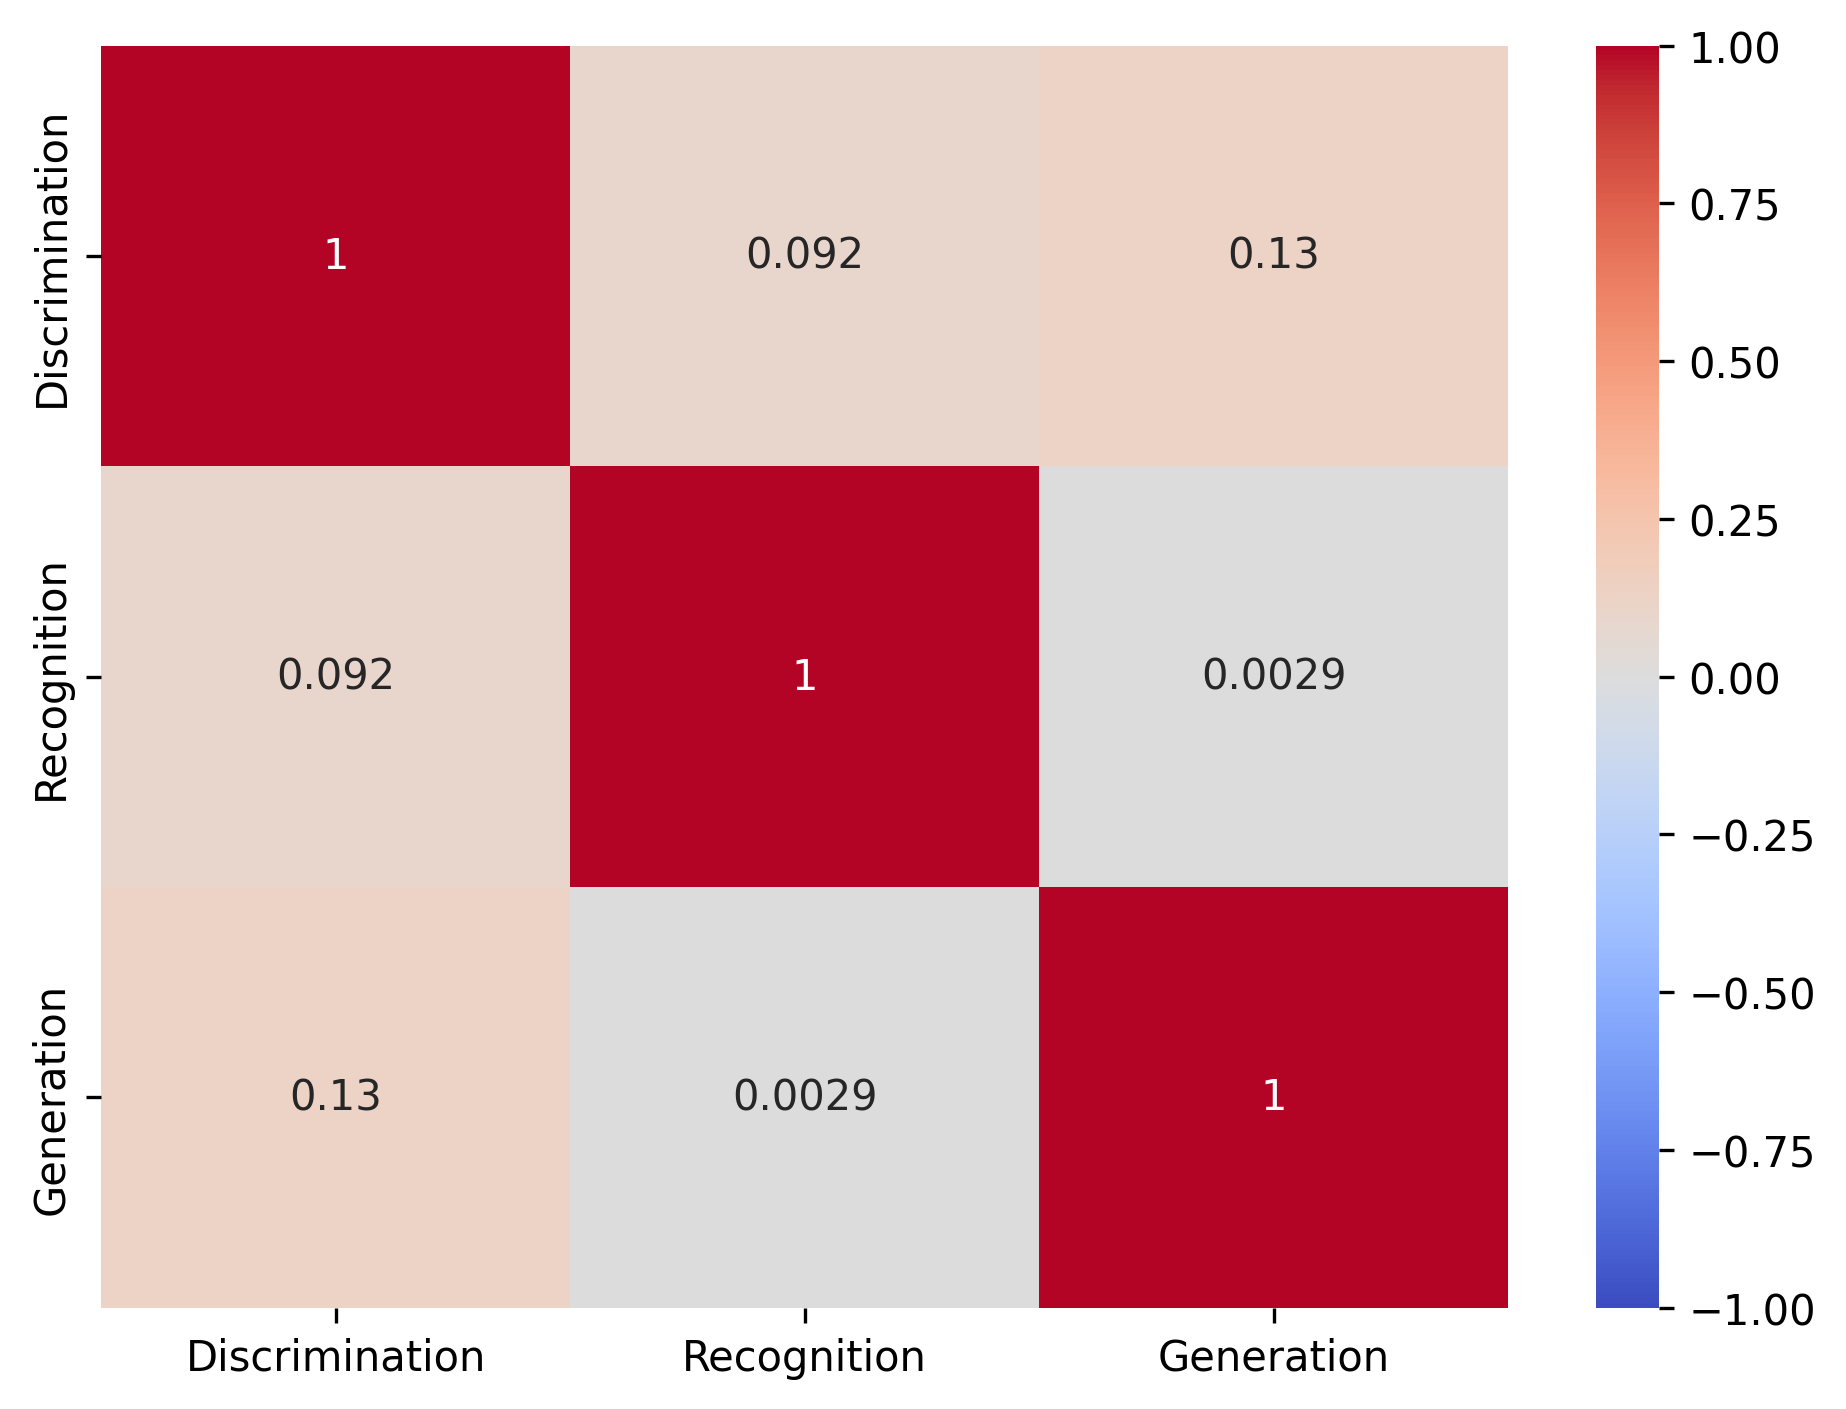

In [58]:
import seaborn as sns
sns.heatmap(df_item_concept[1:].corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True)
plt.tight_layout()
plt.show()

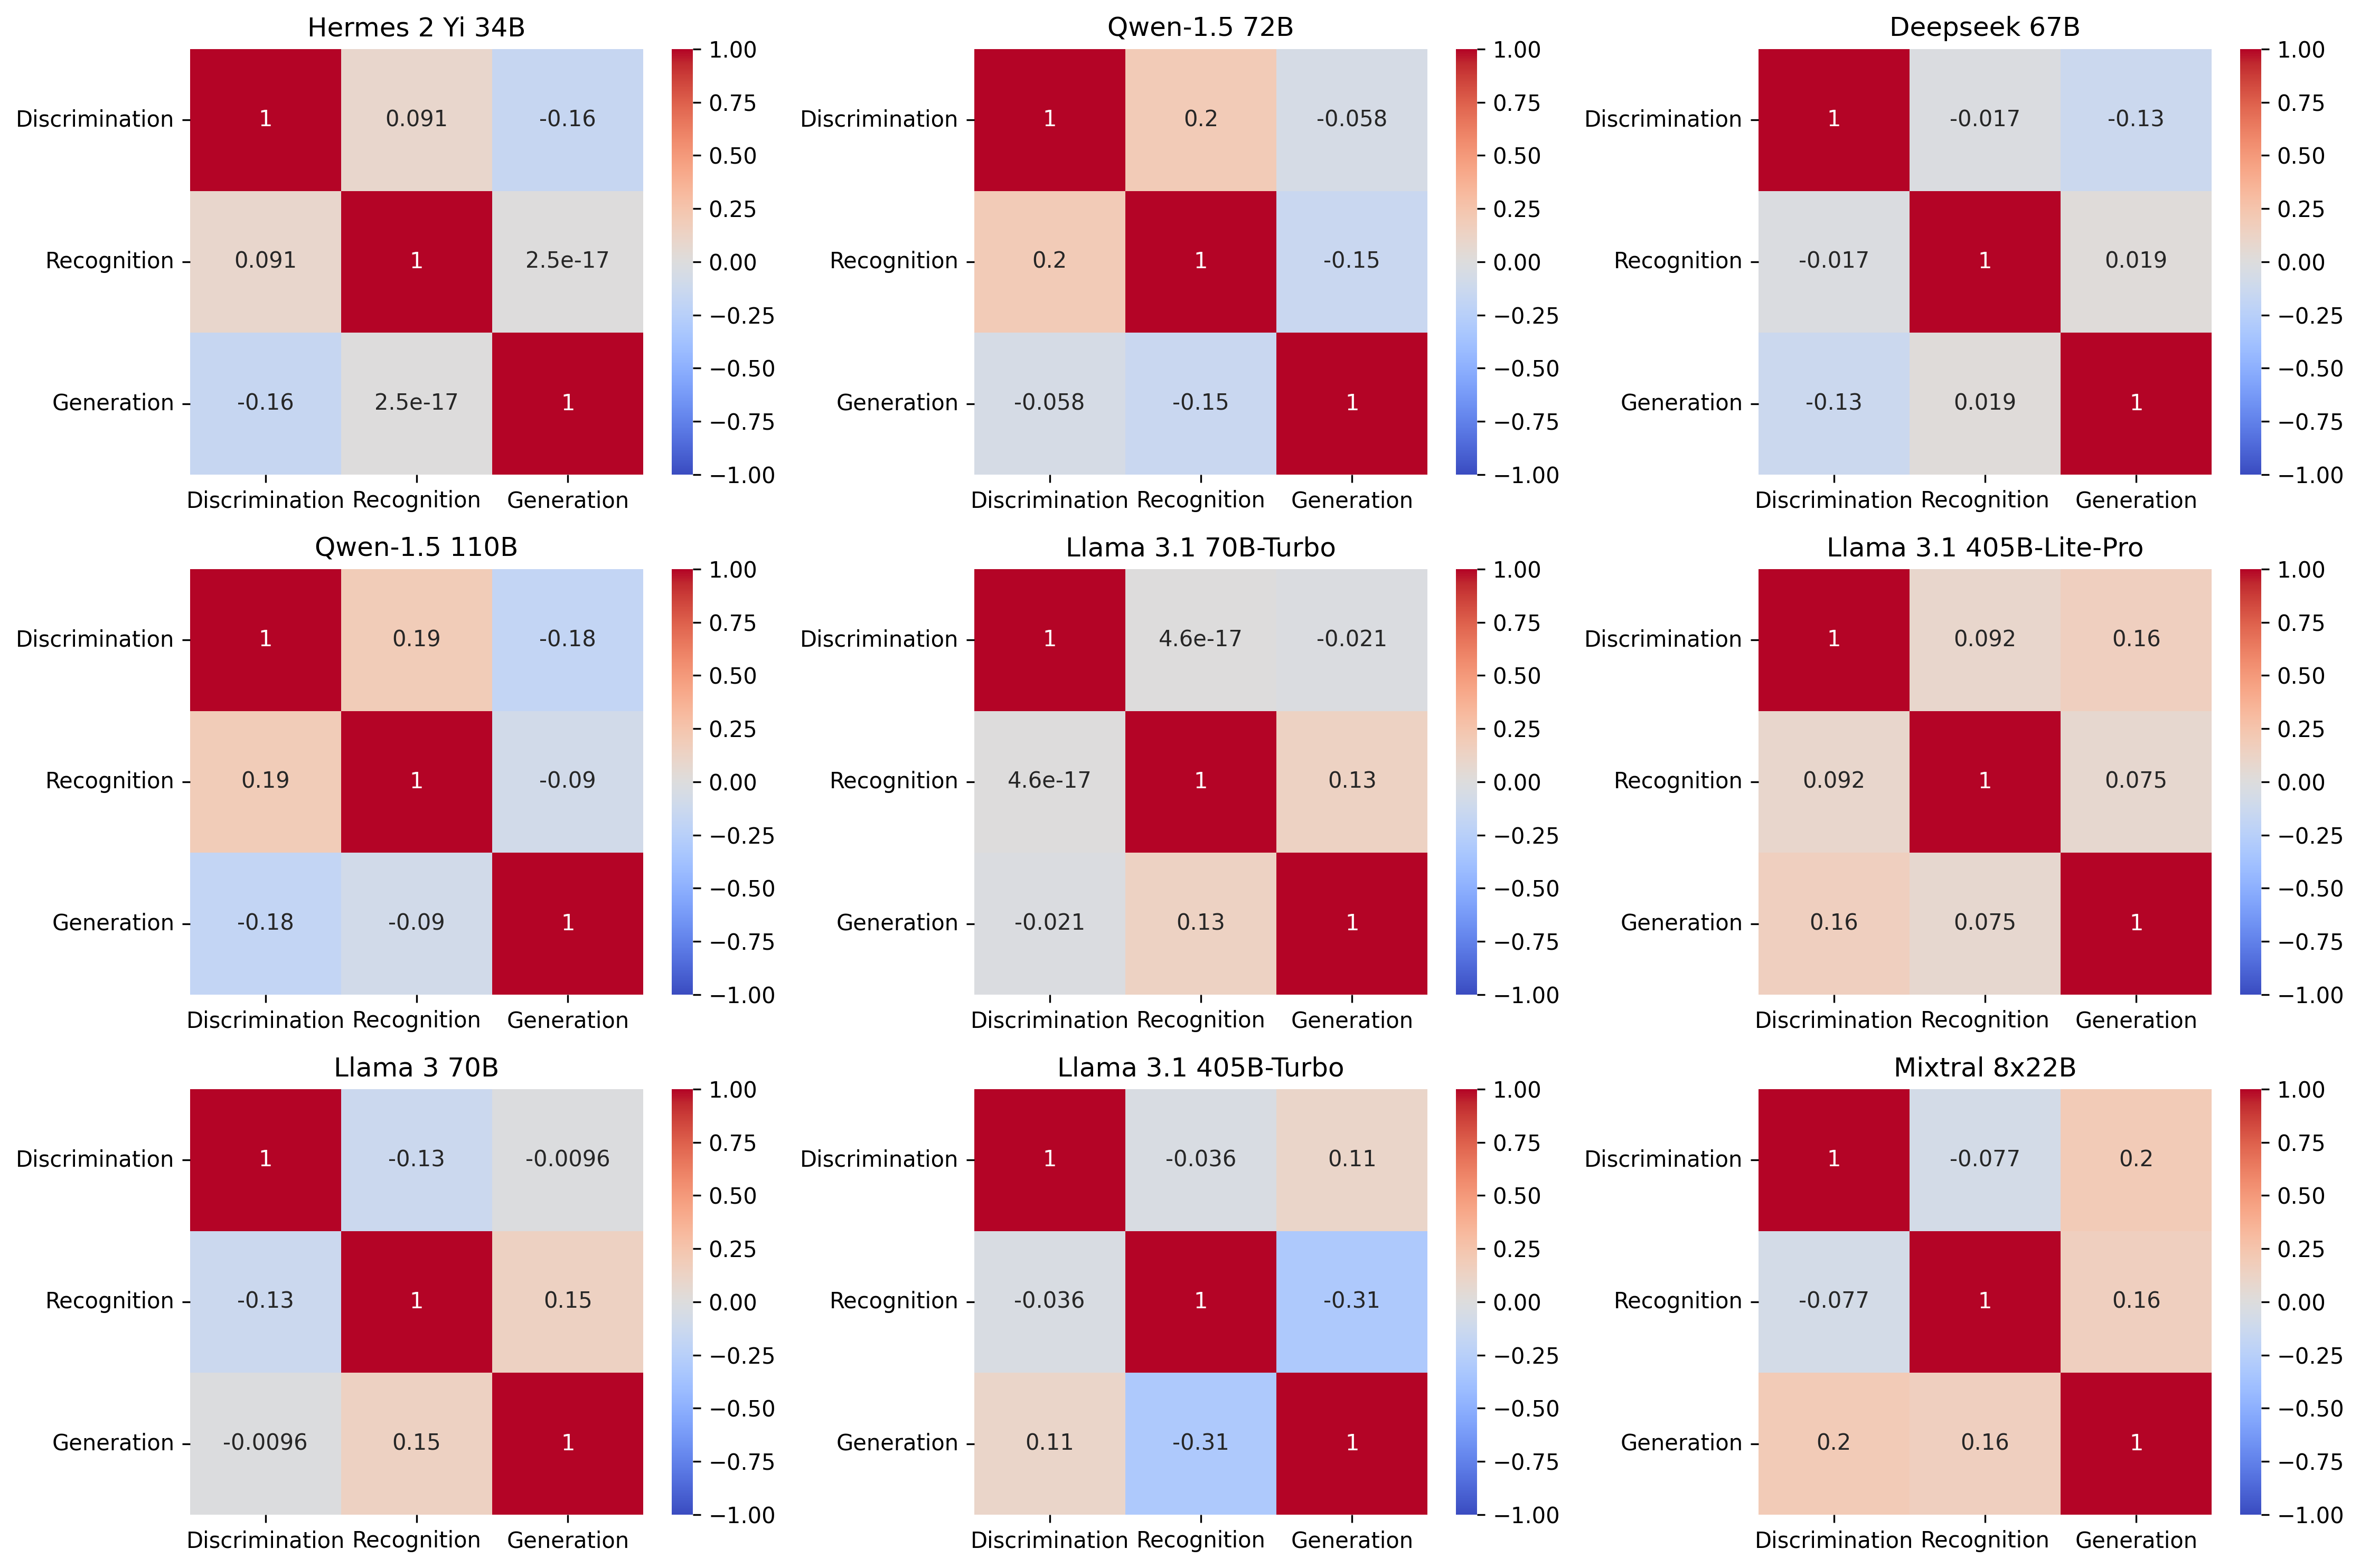

In [125]:
df_con = pd.DataFrame({
    'model': mc_filtered['model'],
    'Discrimination': np.nan,
    'Recognition': np.nan,
    'Generation': np.nan
})
oe_filtered = oe_filtered.loc[oe_filtered['item_id'] != '101']
for model in df_con['model']:
    df_con.loc[df_con['model'] == model, 'Discrimination'] = mc_filtered.loc[mc_filtered['model'] == model, 'concept_response'].values
    df_con.loc[df_con['model'] == model, 'Recognition'] = abcd_filtered.loc[abcd_filtered['model'] == model, 'concept_acc'].astype(float).values
    df_con.loc[df_con['model'] == model, 'Generation'] = oe_filtered.loc[oe_filtered['model'] == model, 'concept_response'].astype(float).values

fig, ax = plt.subplots(3, 3, figsize=(15, 10))
for i, model in enumerate(df_con['model'].unique()):
    df = df_con[df_con['model'] == model]
    sns.heatmap(df[['Discrimination', 'Recognition', 'Generation']].corr(), cmap='coolwarm', vmin=-1, vmax=1, annot=True, ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(names.get(model.split('/')[1], model))

plt.tight_layout()
plt.show()

In [52]:
mc_lp = mc_filtered.groupby('choice')['logprobs'].mean()
mc_lp_err = mc_filtered.groupby('choice')['logprobs'].sem()

abcd_lp = abcd_filtered.groupby('concept_acc')['logprobs'].mean()
abcd_lp_err = abcd_filtered.groupby('concept_acc')['logprobs'].sem()

oe_concept_lp = oe_filtered.groupby('concept_response')['logprobs'].mean().loc[True]
oe_concept_lp_err = oe_filtered.groupby('concept_response')['logprobs'].sem().loc[True]
or_matrix_lp = oe_filtered.groupby('matrix_response')['logprobs'].mean().loc[True]
or_matrix_lp_err = oe_filtered.groupby('matrix_response')['logprobs'].sem().loc[True]

oe_filtered.loc[:, 'other_response'] = oe_filtered['matrix_response'] + oe_filtered['concept_response']
oe_other_lp = oe_filtered.groupby('other_response')['logprobs'].mean().loc[False]
oe_other_lp_err = oe_filtered.groupby('other_response')['logprobs'].sem().loc[False]

/var/folders/9l/dl632xqj3d57xyzhdlhfn4x80000gn/T/ipykernel_95906/305001454.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  oe_filtered.loc[:, 'other_response'] = oe_filtered['matrix_response'] + oe_filtered['concept_response']


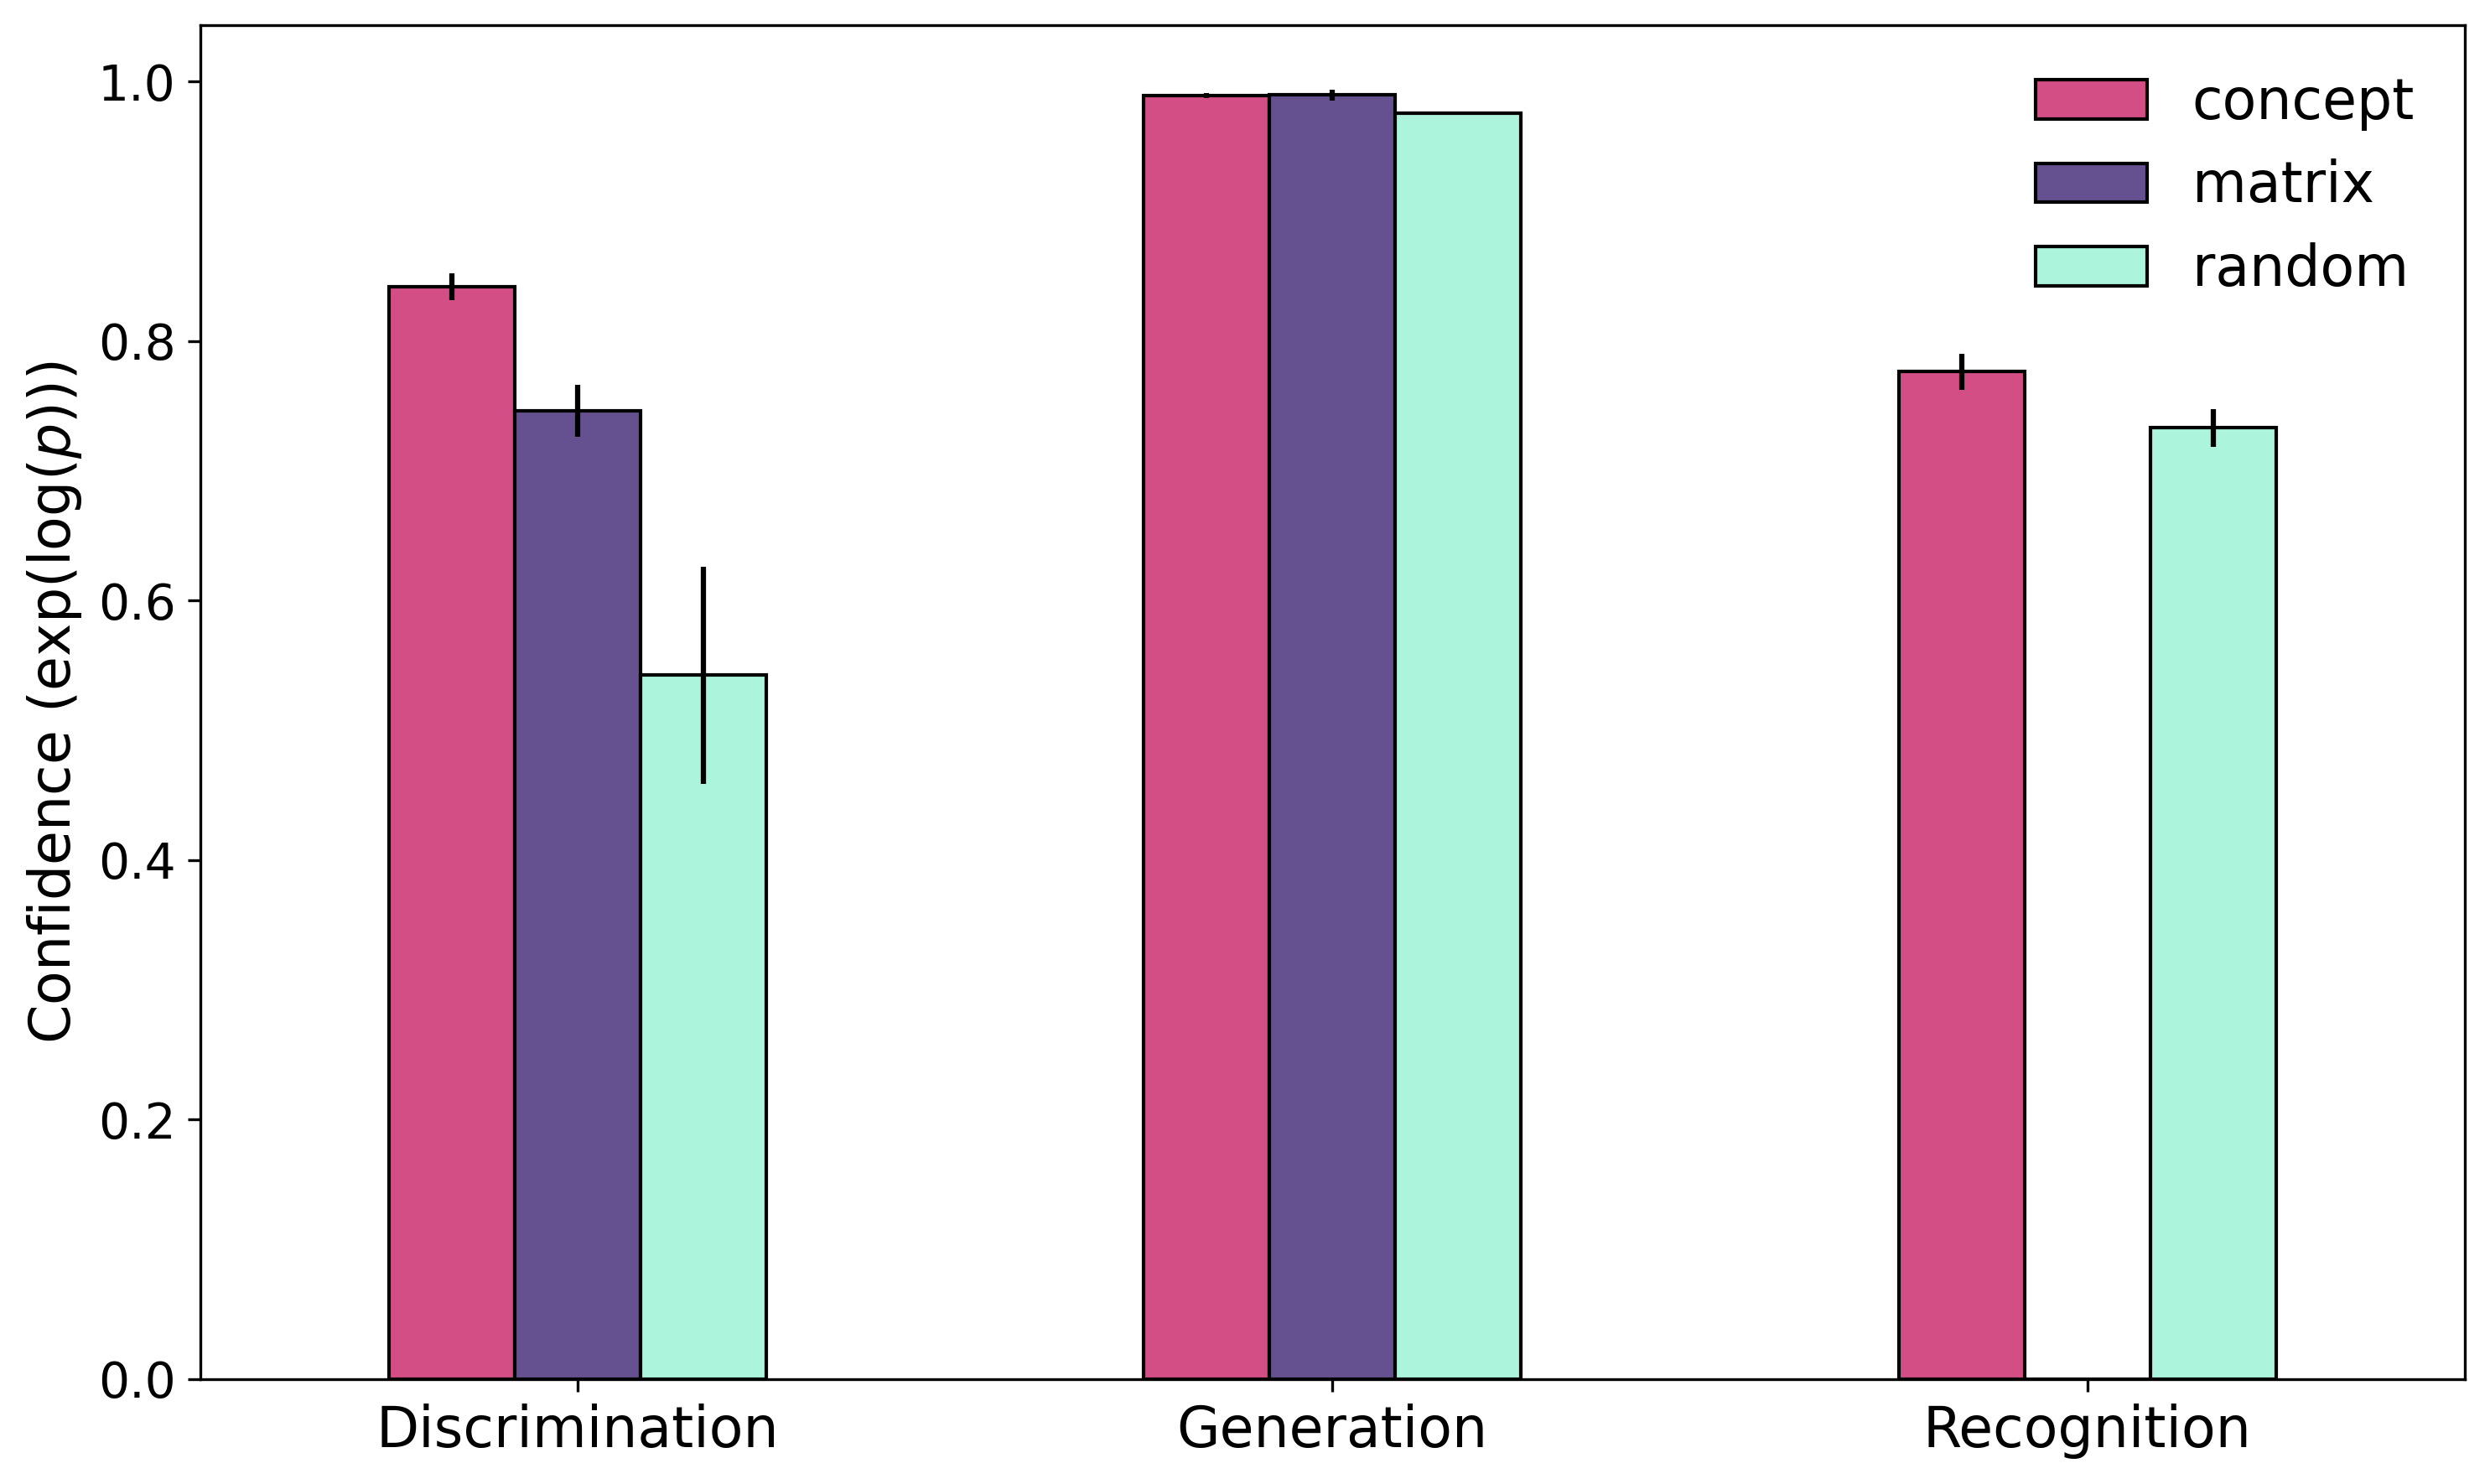

In [54]:
df_lp = pd.DataFrame({
    'Discrimination': mc_lp.to_dict(),
    'Generation': {'concept': oe_concept_lp,
                    'matrix': or_matrix_lp, 
                    'random': oe_other_lp},
    'Recognition': {'concept': abcd_lp.loc[True],
                    'matrix': np.nan,
                    'random': abcd_lp.loc[False]},
}).T
df_lp_err = pd.DataFrame({
    'Discrimination': mc_lp_err,
    'Generation': {'concept': oe_concept_lp_err,
                   'matrix': or_matrix_lp_err, 
                   'random': oe_other_lp_err},
    'Recognition': {'concept': abcd_lp_err.loc[True],
                    'matrix': np.nan,
                    'random': abcd_lp_err.loc[False]},
}).T
plt.rcParams['text.usetex'] = False
df_lp.plot(kind='bar', figsize=(10, 6), color=['#d44e86', '#665190', '#adf4dc'], edgecolor='black', yerr=df_lp_err)
plt.ylabel('Confidence ($\\exp(\\log(p))$)', size=16)
plt.xticks(size=16, rotation=0)
plt.yticks(size=14)
plt.legend(fontsize=16, edgecolor='none')
plt.tight_layout()
plt.show()

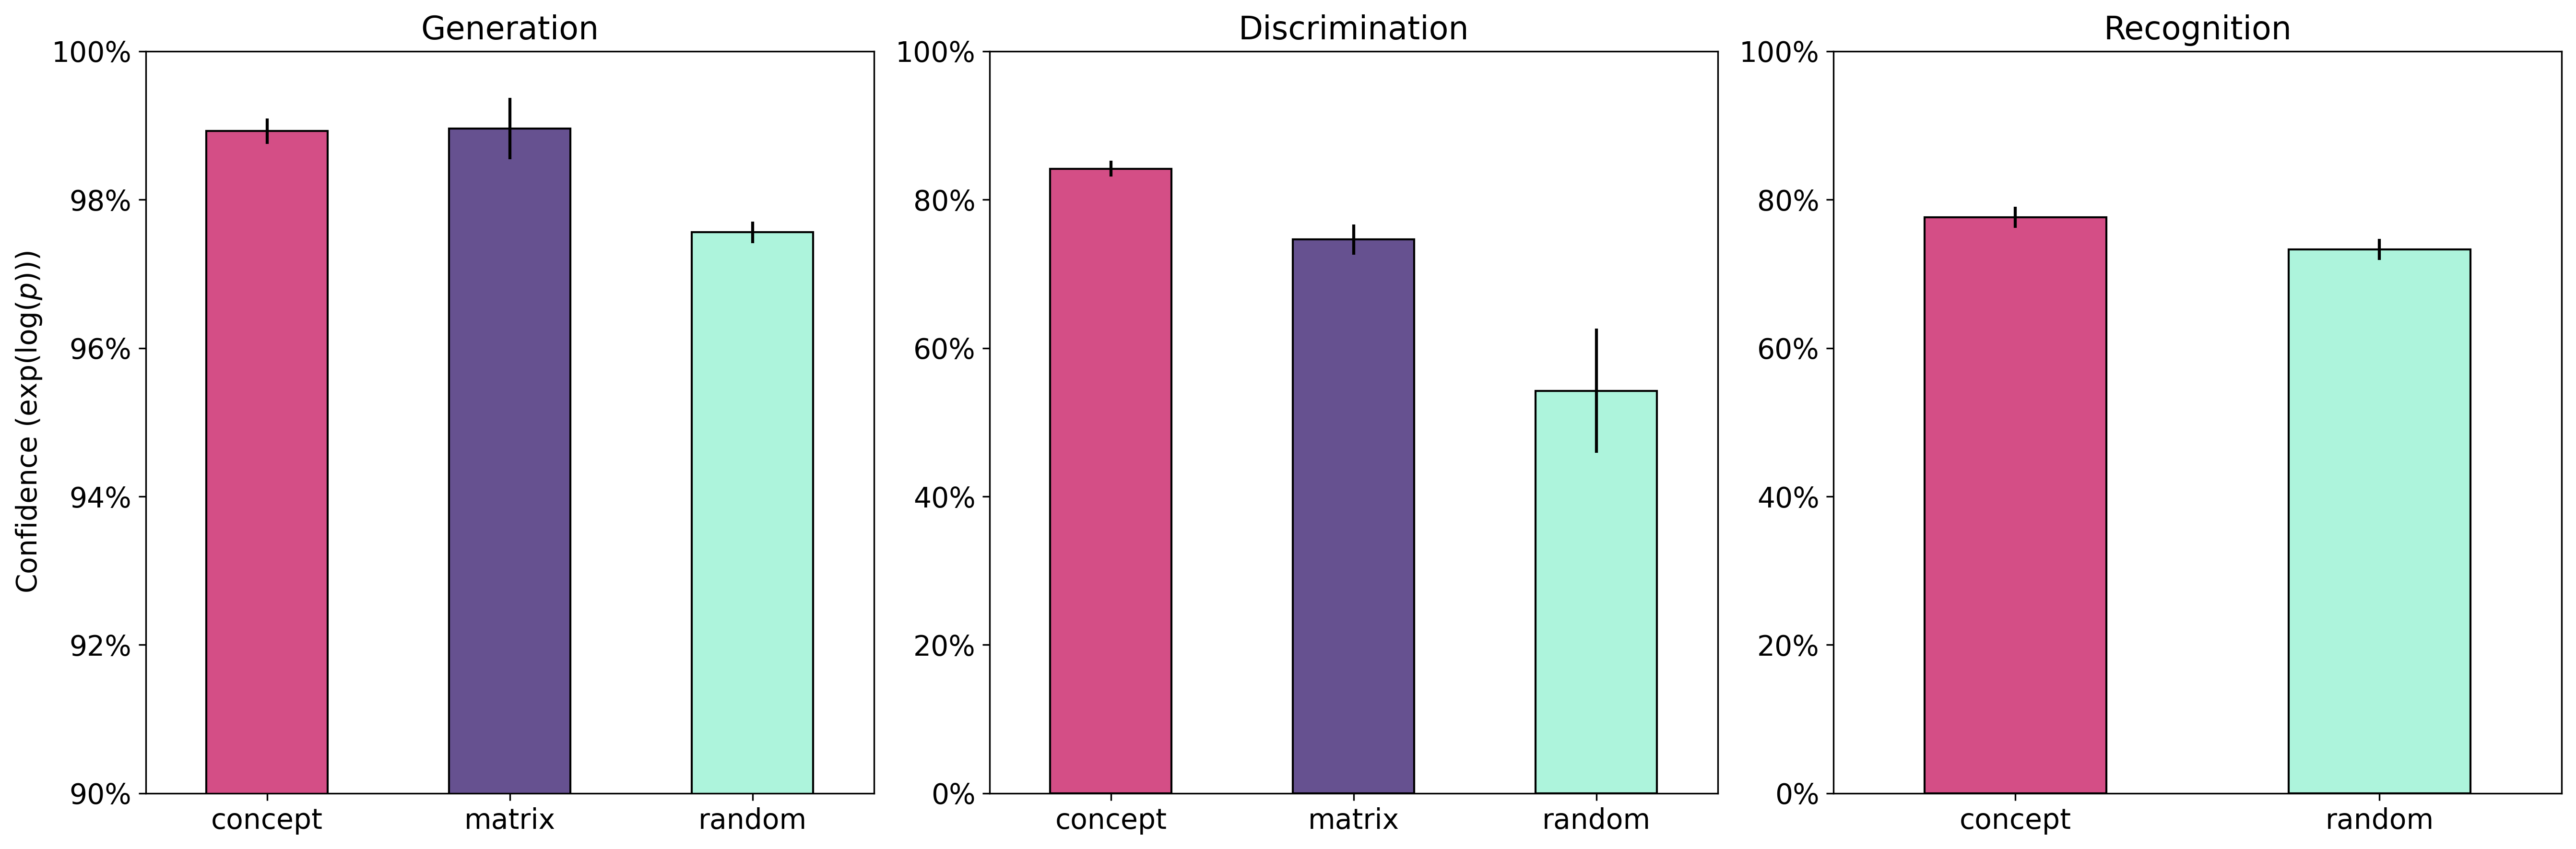

In [55]:
df_lp_t = df_lp.T

# Plot each x category separately in subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharey=False)

df_lp_t['Generation'].plot(kind='bar', ax=axes[0], color=['#d44e86', '#665190', '#adf4dc'], edgecolor='black', yerr=df_lp_err.T['Generation'])
axes[0].set_title('Generation', size=16)
axes[0].tick_params(axis='x', labelsize=14, rotation=0)
axes[0].set_ylabel('Confidence ($\\exp(\\log(p))$)', size=14)
axes[0].set_ylim(0.9, 1)
axes[0].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
axes[0].tick_params(axis='y', labelsize=14)

df_lp_t['Discrimination'].plot(kind='bar', ax=axes[1], color=['#d44e86', '#665190', '#adf4dc'], edgecolor='black', yerr=df_lp_err.T['Discrimination'])
axes[1].set_title('Discrimination', size=16)
axes[1].tick_params(axis='x', labelsize=14, rotation=0)
axes[1].set_ylim(0, 1)
axes[1].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
axes[1].tick_params(axis='y', labelsize=14)

df_lp_t['Recognition'].dropna().plot(kind='bar', ax=axes[2], color=['#d44e86', '#adf4dc'], edgecolor='black', yerr=df_lp_err.T['Recognition'].dropna())
axes[2].set_title('Recognition', size=16)
axes[2].tick_params(axis='x', labelsize=14, rotation=0)
axes[2].set_ylim(0, 1)
axes[2].yaxis.set_major_formatter(plt.FuncFormatter(lambda x, _: f'{x:.0%}'))
axes[2].tick_params(axis='y', labelsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

# Predicting choices

In [203]:
from nltk import edit_distance

# filter items not in dataset
items_data = {
    item_id: item
    for item_id, item in mc_random.dataset.items_data.items()
    if item_id in mc_random.dataset.items
}

edit_distances = {item_id: {} for item_id in items_data.keys()}
for item_id, item in items_data.items():
    # Calculate edit distances between input matrices and the output matrices
    for input_mat in ['A', 'B', 'C']:
        for output_mat in ['D_matrix', 'D_concept', 'D_random']:
            distance = edit_distance(item[input_mat], item[output_mat])
            edit_distances[item_id][f'{input_mat}_{output_mat.split('_')[1]}'] = distance
    
    # Calculate average edit distances between input matrices and the output matrix for all output matrices
    for output_mat in ['D_matrix', 'D_concept', 'D_random']:
        distances = [
            edit_distances[item_id][f'{input_mat}_{output_mat.split('_')[1]}'] 
            for input_mat in ['A', 'B', 'C']
        ]
        edit_distances[item_id][f'{output_mat}_avg'] = np.mean(distances)
    
    # Calculate edit distances between input matrices
    edit_distances[item_id]['A_B'] = edit_distance(item['A'], item['B'])
    edit_distances[item_id]['A_C'] = edit_distance(item['A'], item['C'])
    edit_distances[item_id]['B_C'] = edit_distance(item['B'], item['C'])
    
edit_distances_df = pd.DataFrame(edit_distances).T
edit_distances_df.describe()

A_matrix  A_concept   A_random   B_matrix  B_concept   B_random  \
count  45.000000  45.000000  45.000000  45.000000  45.000000  45.000000   
mean   10.222222  11.111111   7.377778   6.666667   9.844444   7.533333   
std     4.889176   5.292457   3.575732   4.477215   5.431204   3.980635   
min     3.000000   4.000000   1.000000   1.000000   2.000000   1.000000   
25%     6.000000   7.000000   4.000000   4.000000   6.000000   5.000000   
50%     9.000000   9.000000   7.000000   6.000000   9.000000   8.000000   
75%    14.000000  15.000000  11.000000   8.000000  13.000000  10.000000   
max    20.000000  25.000000  14.000000  19.000000  25.000000  19.000000   

        C_matrix  C_concept   C_random  D_matrix_avg  D_concept_avg  \
count  45.000000  45.000000  45.000000     45.000000      45.000000   
mean    5.044444   4.955556   8.622222      7.311111       8.637037   
std     3.930970   2.946150   5.201787      3.390718       3.865688   
min     1.000000   1.000000   1.000000      2.333333       3.333333   
25%     2.000000   3.000000   4.000000      4.333333       6.000000   
50%     4.000000   4.000000   8.000000      7.000000       8.000000   
75%     7.000000   6.000000  12.000000     10.000000      11.000000   
max    17.000000  14.000000  25.000000     15.000000      18.666667   

       D_random_avg        A_B        A_C        B_C  
count     45.000000  45.000000  45.000000  45.000000  
mean       7.844444   5.133333   9.266667  11.155556  
std        3.663635   3.653143   5.369950   5.334091  
min        2.000000   1.000000   2.000000   4.000000  
25%        4.333333   2.000000   5.000000   7.000000  
50%        7.333333   4.000000   9.000000   9.000000  
75%       11.000000   6.000000  12.000000  15.000000  
max       15.000000  16.000000  25.000000  25.000000

<Axes: xlabel='item_id'>

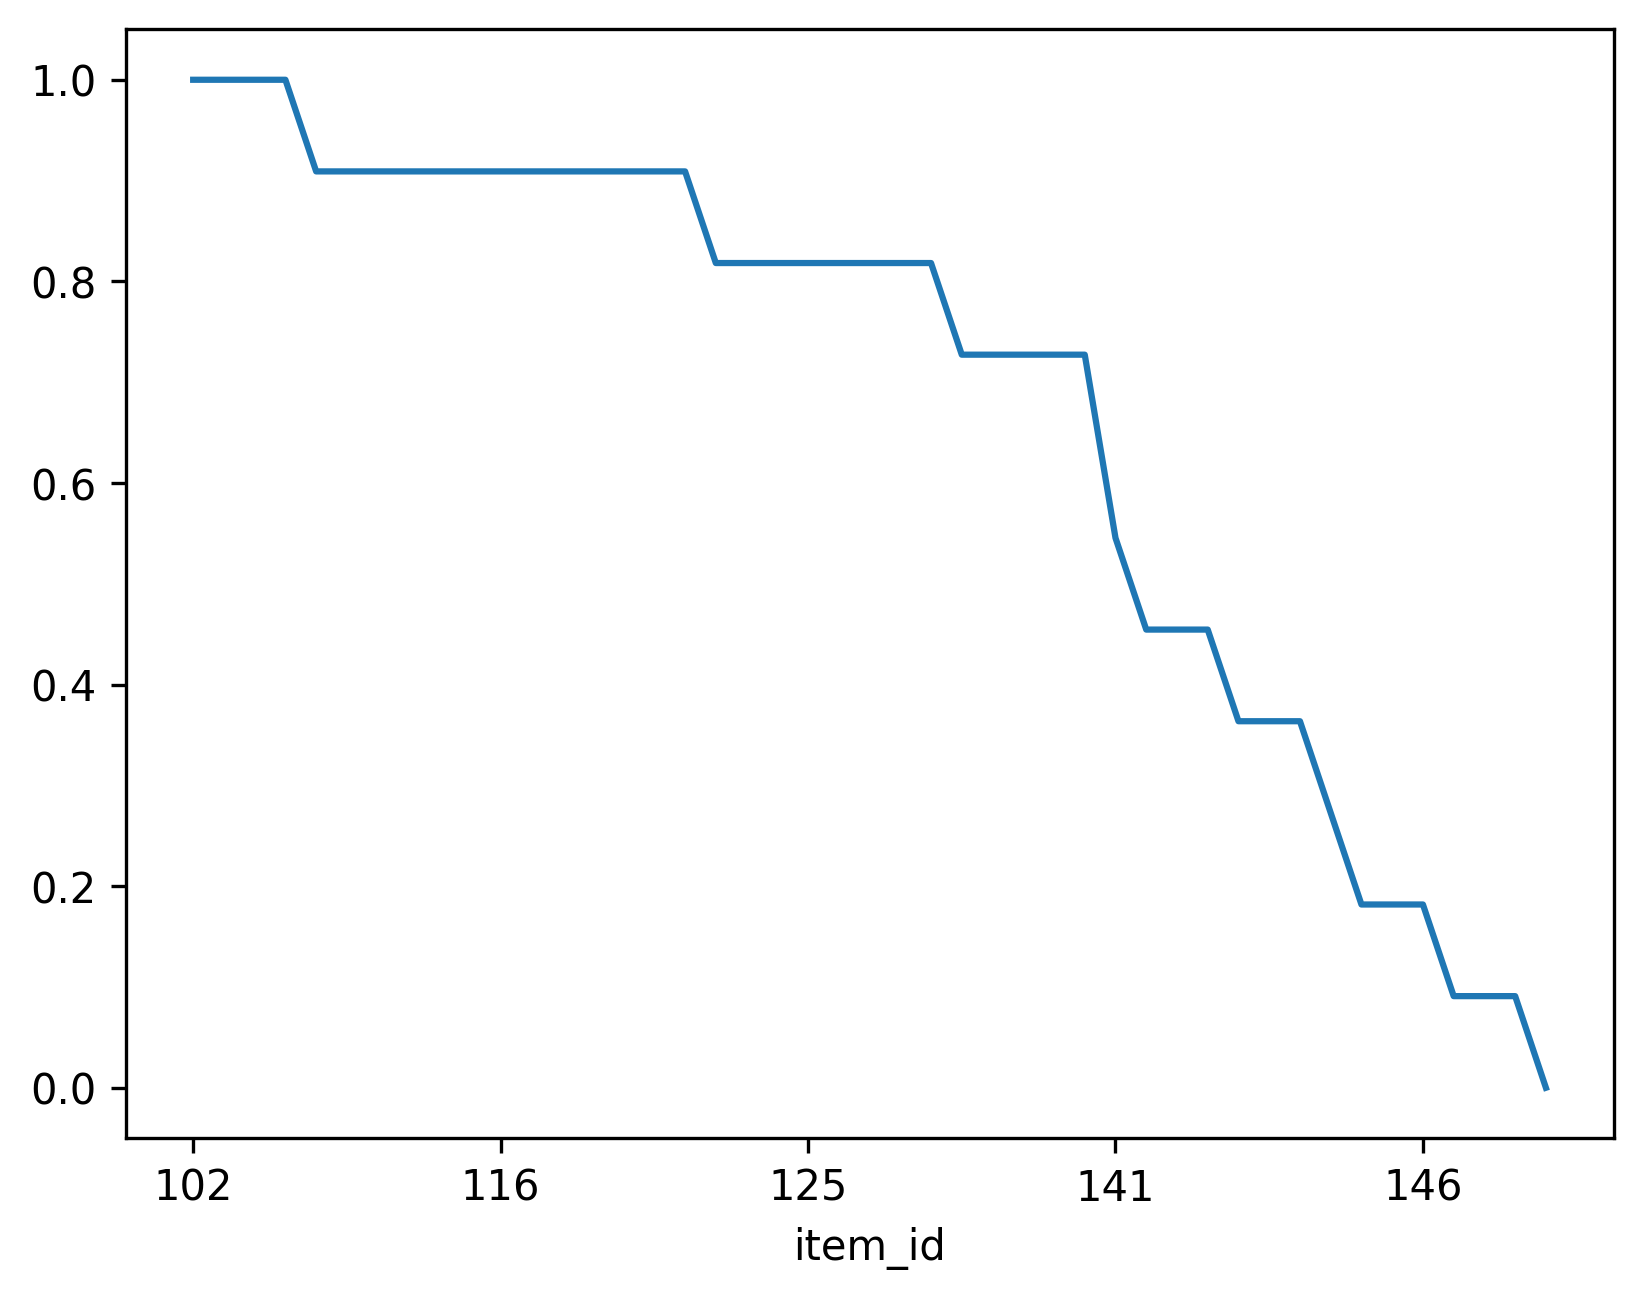

In [272]:
mc_random.df['concept_response'].groupby(mc_random.df['item_id']).mean().sort_values(ascending=False).plot(kind='line')

In [265]:
edit_df = mc_random.df[['item_id', 'model', 'choice']]
edit_df = edit_df.merge(edit_distances_df, left_on='item_id', right_index=True)
edit_df = edit_df[edit_df['choice'] != 'random']

from sklearn.linear_model import LogisticRegression

X = edit_df.drop(columns=['item_id', 'model', 'choice'])
y = edit_df['choice']

lr = LogisticRegression(max_iter=1000)
fit = lr.fit(X, y)

# get importance
importance = lr.coef_[0]

# summarize feature importance
for i,v in enumerate(importance):
    print(f'Feature: {X.columns[i]}, Score: {v:.2f}')

Feature: A_matrix, Score: -0.02
Feature: A_concept, Score: 0.00
Feature: A_random, Score: 0.40
Feature: B_matrix, Score: 0.68
Feature: B_concept, Score: -0.02
Feature: B_random, Score: -0.26
Feature: C_matrix, Score: 0.44
Feature: C_concept, Score: -0.11
Feature: C_random, Score: -0.24
Feature: D_matrix_avg, Score: 0.37
Feature: D_concept_avg, Score: -0.04
Feature: D_random_avg, Score: -0.03
Feature: A_B, Score: 0.23
Feature: A_C, Score: -0.07
Feature: B_C, Score: -0.48


In [ ]:
filtered_df = abcd.df[abcd.df['model'].isin(list(df[df['4 Answer Options'] > 0.3].index))]
filtered_df.groupby('item_id')['concept_acc'].mean().sort_values(ascending=False).plot(kind='bar')
plt.ylabel('Accuracy')
plt.xticks(ticks=plt.gca().get_xticks(), labels=[])
plt.ylim(0, 1)
plt.show()

In [266]:
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import pandas as pd

# Standardize the predictor variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # This returns a numpy array

# Convert back to DataFrame with original column names
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

# Add a constant to the features for the intercept term
X_scaled_with_constant = sm.add_constant(X_scaled).reset_index(drop=True)

# Get dummy variables for the target variable
y = pd.get_dummies(y)['concept'].reset_index(drop=True)

# Fit the logistic regression model using statsmodels
logit_model = sm.Logit(y, X_scaled_with_constant)
result = logit_model.fit()

# Get the summary of the logistic regression
summary_table = result.summary2().tables[1]

# Extracting relevant information: coefficients and p-values
coef_pvalues_df = summary_table[['Coef.', 'P>|z|']].reset_index()
coef_pvalues_df.columns = ['Feature', 'Standardized Coefficient', 'P-value']

# sort by p-values
coef_pvalues_df = coef_pvalues_df.sort_values(by='P-value')

styled_df = coef_pvalues_df.style.background_gradient(
    subset=['Standardized Coefficient'], cmap='coolwarm', axis=0
)

# Display the styled DataFrame
styled_df


         Current function value: 0.503825
         Iterations: 35


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


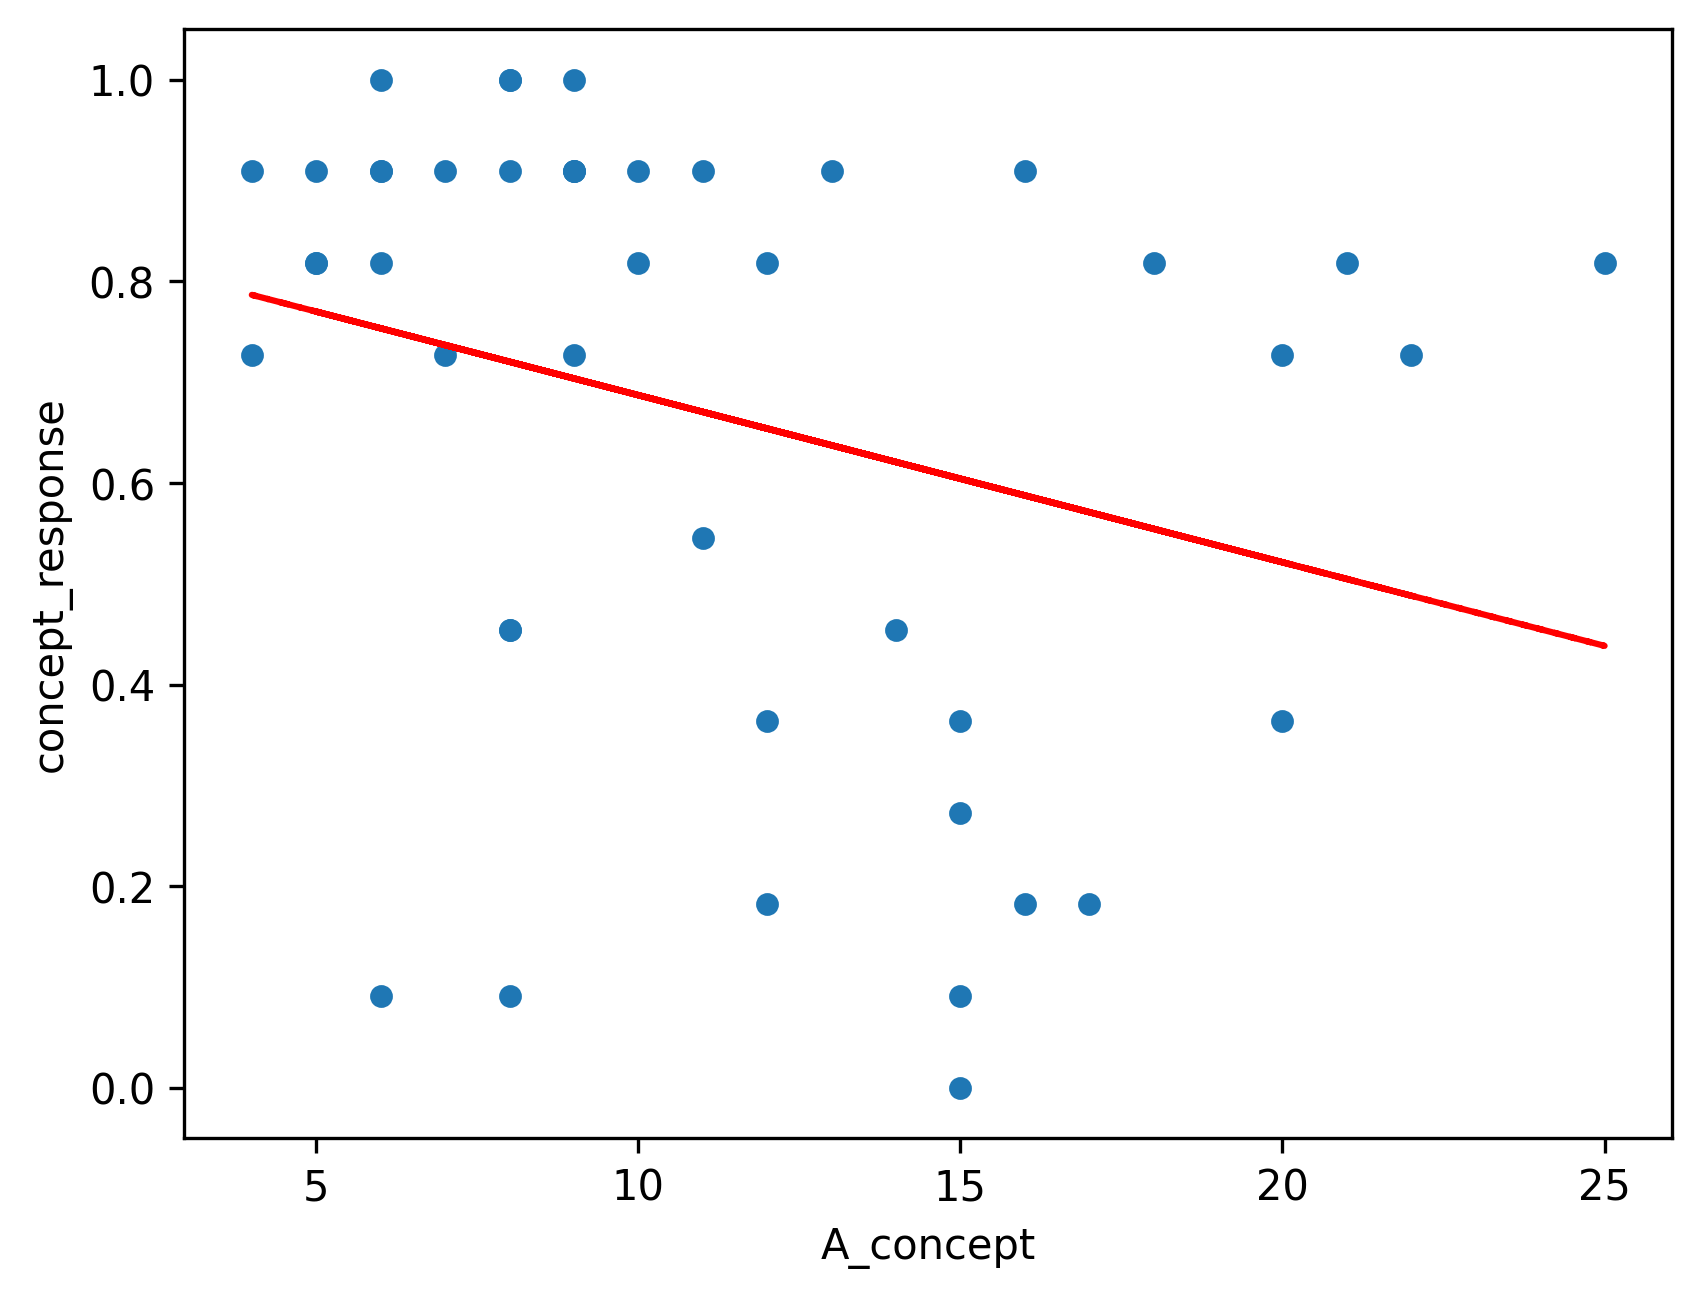

In [286]:
feat = 'A_concept'
df_interp = pd.DataFrame({
    'concept_response': mc_random.df['concept_response'].groupby(mc_random.df['item_id']).mean(),
    feat: edit_distances_df[feat],
})
df_interp.plot(kind='scatter', x=feat, y='concept_response')
# Add a trendline
z = np.polyfit(df_interp[feat], df_interp['concept_response'], 1)
p = np.poly1d(z)
plt.plot(df_interp[feat], p(df_interp[feat]), 'r--')
plt.show()


In [273]:
mc_random.df['concept_response'].groupby(mc_random.df['item_id']).mean()

item_id
102    1.000000
103    0.909091
104    0.727273
105    1.000000
106    0.909091
107    0.818182
108    0.909091
109    0.909091
110    0.909091
111    1.000000
112    0.909091
113    0.727273
114    0.909091
115    0.818182
116    0.909091
117    0.727273
118    0.818182
119    0.090909
120    0.454545
121    0.818182
122    0.818182
123    0.909091
124    0.909091
125    0.818182
126    0.909091
127    0.727273
128    0.363636
129    0.181818
130    0.454545
131    0.363636
132    0.454545
133    0.909091
134    0.818182
135    0.272727
136    0.909091
137    0.818182
138    0.090909
139    0.727273
140    0.090909
141    0.545455
142    0.000000
143    1.000000
144    0.181818
145    0.363636
146    0.181818
Name: concept_response, dtype: float64

In [244]:
X_scaled

A_matrix  A_concept  A_random  B_matrix  B_concept  B_random  C_matrix  \
0   -1.273845  -0.966939 -0.940000 -0.372732  -0.711653 -0.649606 -1.038638   
1   -1.273845  -0.966939 -0.940000 -0.372732  -0.711653 -0.649606 -1.038638   
2   -1.273845  -0.966939 -0.940000 -0.372732  -0.711653 -0.649606 -1.038638   
3   -1.273845  -0.966939 -0.940000 -0.372732  -0.711653 -0.649606 -1.038638   
4   -1.273845  -0.966939 -0.940000 -0.372732  -0.711653 -0.649606 -1.038638   
..        ...        ...       ...       ...        ...       ...       ...   
462  0.597518   1.149450  1.309737 -0.372732   0.965901  1.430023  2.371623   
463  0.597518   1.149450  1.309737 -0.372732   0.965901  1.430023  2.371623   
464  0.597518   1.149450  1.309737 -0.372732   0.965901  1.430023  2.371623   
465  0.597518   1.149450  1.309737 -0.372732   0.965901  1.430023  2.371623   
466  0.597518   1.149450  1.309737 -0.372732   0.965901  1.430023  2.371623   

     C_concept  C_random  D_matrix_avg  D_concept_avg  D_random_avg       A_B  \
0    -1.340236 -0.687552     -1.173723      -1.111268     -0.864508 -1.141364   
1    -1.340236 -0.687552     -1.173723      -1.111268     -0.864508 -1.141364   
2    -1.340236 -0.687552     -1.173723      -1.111268     -0.864508 -1.141364   
3    -1.340236 -0.687552     -1.173723      -1.111268     -0.864508 -1.141364   
4    -1.340236 -0.687552     -1.173723      -1.111268     -0.864508 -1.141364   
..         ...       ...           ...            ...           ...       ...   
462   0.377355 -0.298827      1.027597       1.068513      0.794637  0.825488   
463   0.377355 -0.298827      1.027597       1.068513      0.794637  0.825488   
464   0.377355 -0.298827      1.027597       1.068513      0.794637  0.825488   
465   0.377355 -0.298827      1.027597       1.068513      0.794637  0.825488   
466   0.377355 -0.298827      1.027597       1.068513      0.794637  0.825488   

         A_C       B_C  
0   -0.79805 -0.967010  
1   -0.79805 -0.967010  
2   -0.79805 -0.967010  
3   -0.79805 -0.967010  
4   -0.79805 -0.967010  
..       ...       ...  
462  1.08422  1.133425  
463  1.08422  1.133425  
464  1.08422  1.133425  
465  1.08422  1.133425  
466  1.08422  1.133425  

[467 rows x 15 columns]

In [245]:
X_scaled_with_constant

const  A_matrix  A_concept  A_random  B_matrix  B_concept  B_random  \
0      1.0 -1.273845  -0.966939 -0.940000 -0.372732  -0.711653 -0.649606   
1      1.0 -1.273845  -0.966939 -0.940000 -0.372732  -0.711653 -0.649606   
2      1.0 -1.273845  -0.966939 -0.940000 -0.372732  -0.711653 -0.649606   
3      1.0 -1.273845  -0.966939 -0.940000 -0.372732  -0.711653 -0.649606   
4      1.0 -1.273845  -0.966939 -0.940000 -0.372732  -0.711653 -0.649606   
..     ...       ...        ...       ...       ...        ...       ...   
462    1.0  0.597518   1.149450  1.309737 -0.372732   0.965901  1.430023   
463    1.0  0.597518   1.149450  1.309737 -0.372732   0.965901  1.430023   
464    1.0  0.597518   1.149450  1.309737 -0.372732   0.965901  1.430023   
465    1.0  0.597518   1.149450  1.309737 -0.372732   0.965901  1.430023   
466    1.0  0.597518   1.149450  1.309737 -0.372732   0.965901  1.430023   

     C_matrix  C_concept  C_random  D_matrix_avg  D_concept_avg  D_random_avg  \
0   -1.038638  -1.340236 -0.687552     -1.173723      -1.111268     -0.864508   
1   -1.038638  -1.340236 -0.687552     -1.173723      -1.111268     -0.864508   
2   -1.038638  -1.340236 -0.687552     -1.173723      -1.111268     -0.864508   
3   -1.038638  -1.340236 -0.687552     -1.173723      -1.111268     -0.864508   
4   -1.038638  -1.340236 -0.687552     -1.173723      -1.111268     -0.864508   
..        ...        ...       ...           ...            ...           ...   
462  2.371623   0.377355 -0.298827      1.027597       1.068513      0.794637   
463  2.371623   0.377355 -0.298827      1.027597       1.068513      0.794637   
464  2.371623   0.377355 -0.298827      1.027597       1.068513      0.794637   
465  2.371623   0.377355 -0.298827      1.027597       1.068513      0.794637   
466  2.371623   0.377355 -0.298827      1.027597       1.068513      0.794637   

          A_B      A_C       B_C  
0   -1.141364 -0.79805 -0.967010  
1   -1.141364 -0.79805 -0.967010  
2   -1.141364 -0.79805 -0.967010  
3   -1.141364 -0.79805 -0.967010  
4   -1.141364 -0.79805 -0.967010  
..        ...      ...       ...  
462  0.825488  1.08422  1.133425  
463  0.825488  1.08422  1.133425  
464  0.825488  1.08422  1.133425  
465  0.825488  1.08422  1.133425  
466  0.825488  1.08422  1.133425  

[467 rows x 16 columns]

<Axes: >

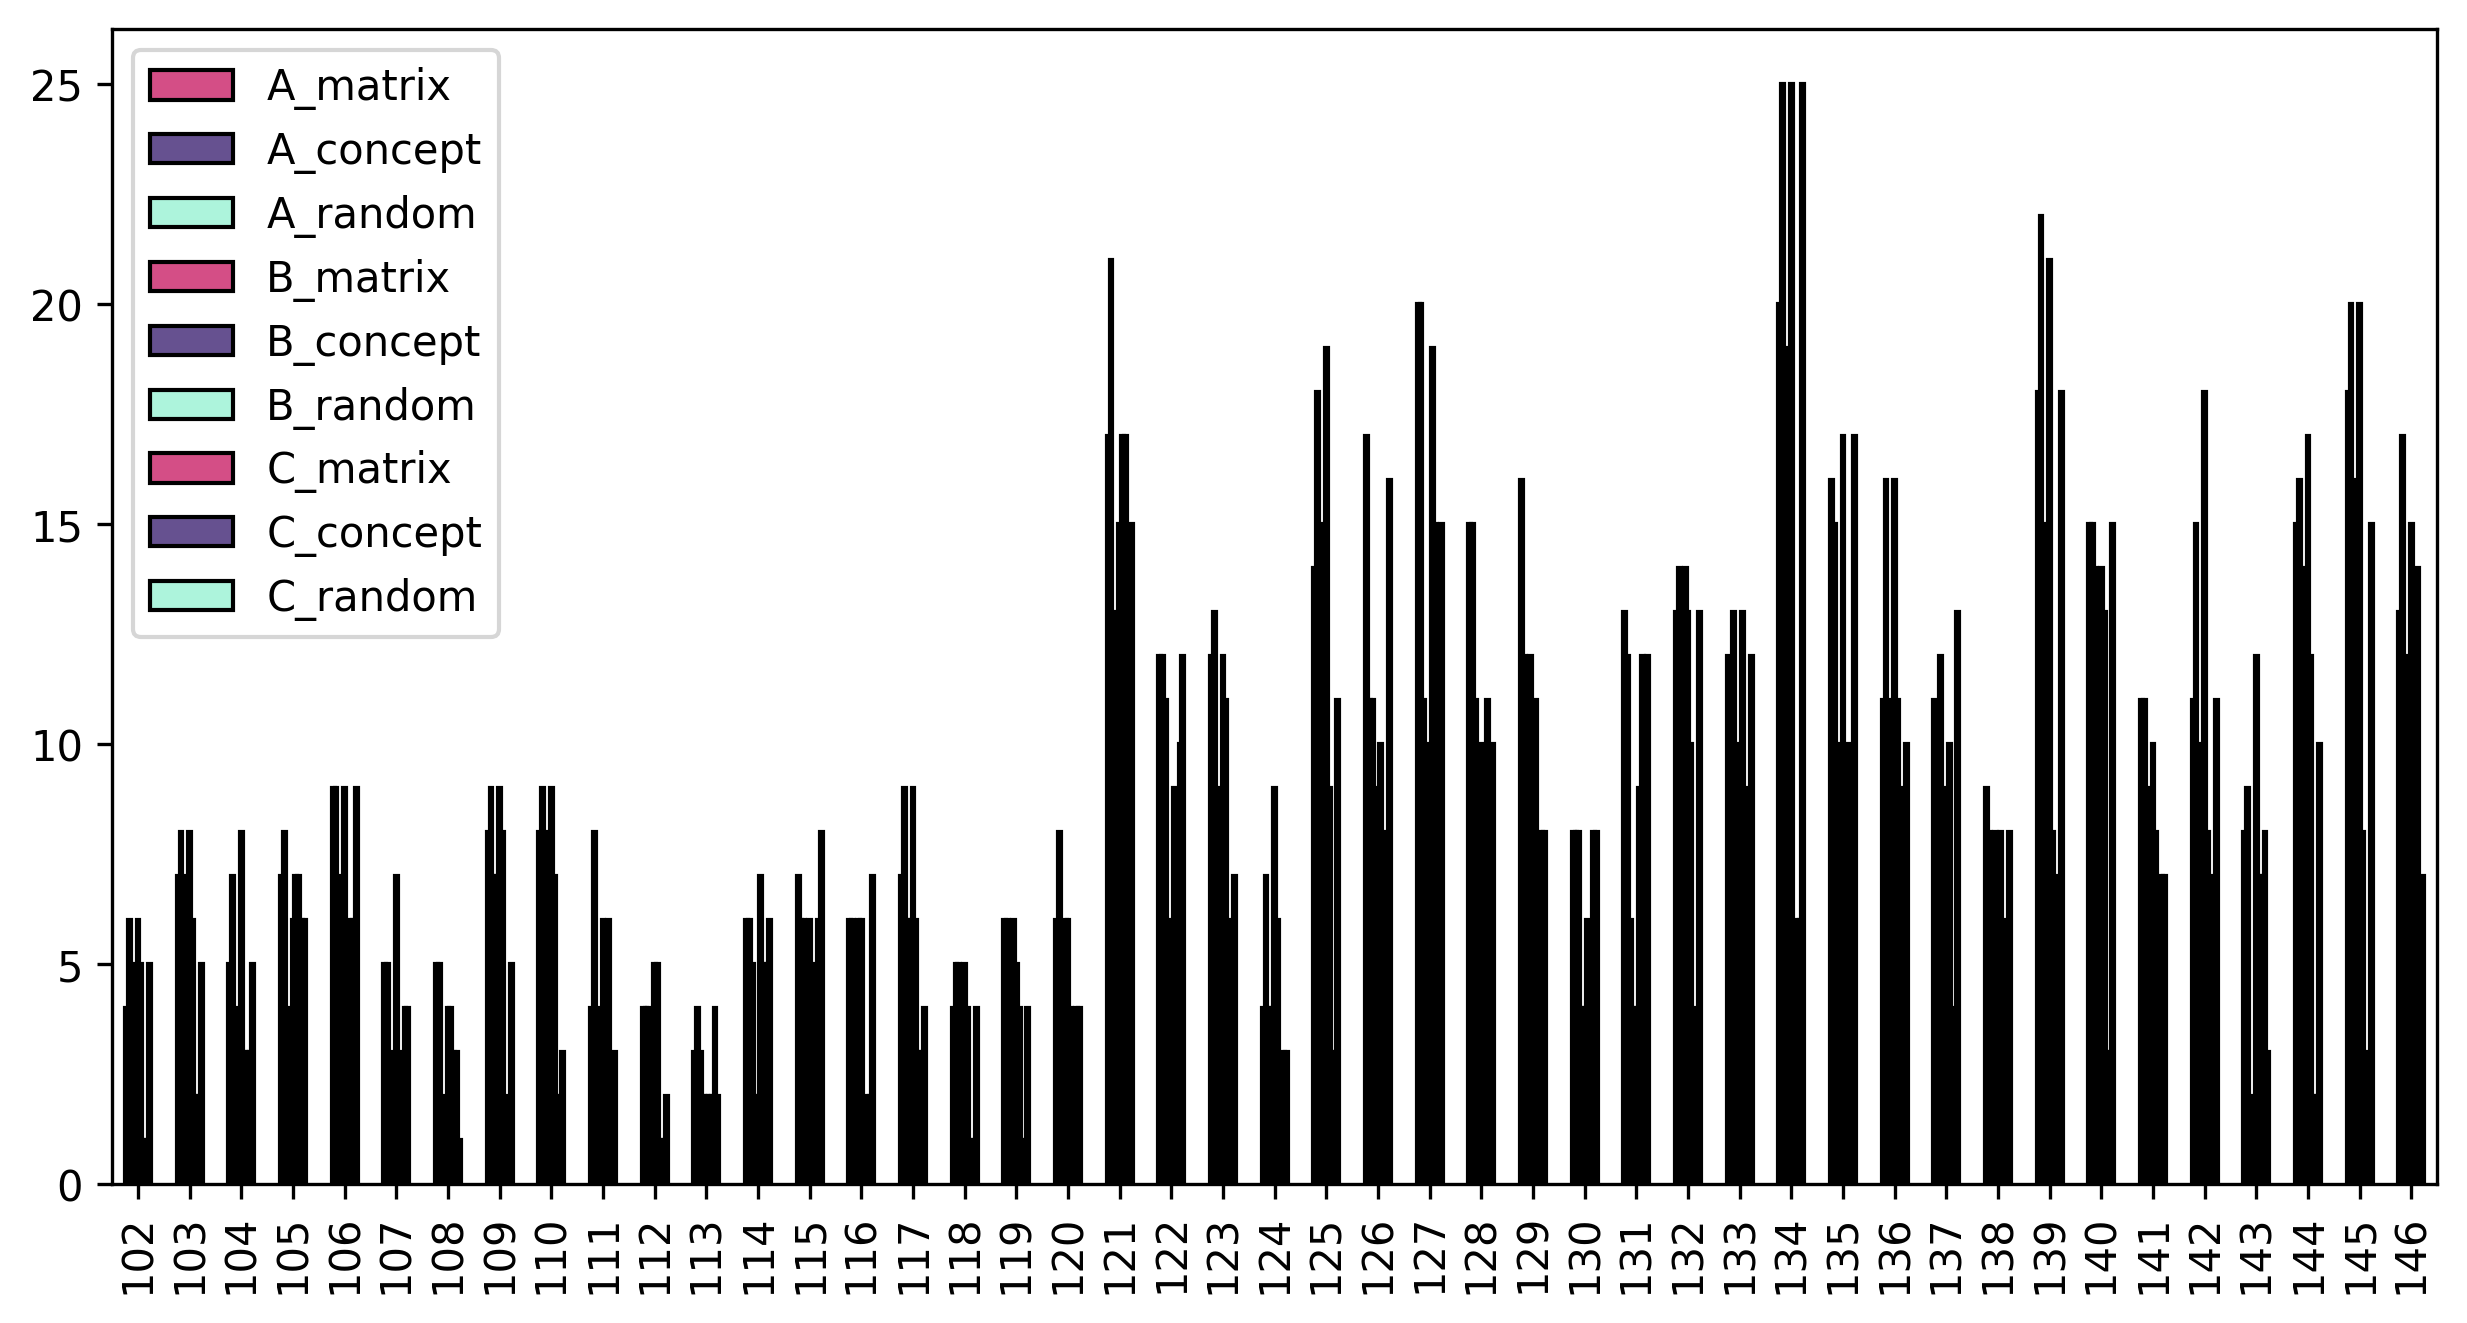

In [171]:
edit_distances_df.plot(kind='bar', figsize=(10, 5), color=['#d44e86', '#665190', '#adf4dc'], edgecolor='black')

In [163]:
edit_distances

{'102_A_matrix': 4,
 '102_A_concept': 6,
 '102_A_random': 4,
 '102_B_matrix': 5,
 '102_B_concept': 6,
 '102_B_random': 5,
 '102_C_matrix': 1,
 '102_C_concept': 1,
 '102_C_random': 5,
 '103_A_matrix': 7,
 '103_A_concept': 8,
 '103_A_random': 7,
 '103_B_matrix': 6,
 '103_B_concept': 8,
 '103_B_random': 6,
 '103_C_matrix': 2,
 '103_C_concept': 2,
 '103_C_random': 5,
 '104_A_matrix': 5,
 '104_A_concept': 7,
 '104_A_random': 3,
 '104_B_matrix': 4,
 '104_B_concept': 8,
 '104_B_random': 3,
 '104_C_matrix': 3,
 '104_C_concept': 3,
 '104_C_random': 5,
 '105_A_matrix': 7,
 '105_A_concept': 8,
 '105_A_random': 4,
 '105_B_matrix': 1,
 '105_B_concept': 6,
 '105_B_random': 7,
 '105_C_matrix': 7,
 '105_C_concept': 6,
 '105_C_random': 6,
 '106_A_matrix': 9,
 '106_A_concept': 9,
 '106_A_random': 7,
 '106_B_matrix': 3,
 '106_B_concept': 9,
 '106_B_random': 4,
 '106_C_matrix': 6,
 '106_C_concept': 6,
 '106_C_random': 9,
 '107_A_matrix': 5,
 '107_A_concept': 5,
 '107_A_random': 3,
 '107_B_matrix': 2,
 '10

In [157]:
for 
    input_matrices

['0100122222010010100101001',
 '0000022222000000000000000',
 '1010010100222221010022222']

In [150]:
mc_random.dataset.items_data.keys() 

dict_keys(['example', '101', '102', '103', '104', '105', '106', '107', '108', '109', '110', '111', '112', '113', '114', '115', '116', '117', '118', '119', '120', '121', '122', '123', '124', '125', '126', '127', '128', '129', '130', '131', '132', '133', '134', '135', '136', '137', '138', '139', '140', '141', '142', '143', '144', '145', '146'])

In [153]:
{k: v for k, v in mc_random.dataset.items_data.items() if k in mc_random.dataset.items}

{'102': {'xdim': 3,
  'ydim': 3,
  'A': '030232030',
  'B': '030222030',
  'C': '300311300',
  'D_matrix': '300321300',
  'D_concept': '300111300',
  'concept': 'top_and_bottom_3d',
  'D_random': '233033030'},
 '103': {'xdim': 3,
  'ydim': 3,
  'A': '550005555',
  'B': '555505555',
  'C': '606606066',
  'D_matrix': '605506066',
  'D_concept': '666606666',
  'concept': 'complete_shape',
  'D_random': '605555606'},
 '104': {'xdim': 3,
  'ydim': 3,
  'A': '006060600',
  'B': '006066666',
  'C': '200020002',
  'D_matrix': '200026066',
  'D_concept': '222022002',
  'concept': 'filled_and_not_filled',
  'D_random': '000066060'},
 '105': {'xdim': 3,
  'ydim': 3,
  'A': '222300550',
  'B': '300550222',
  'C': '110444600',
  'D_matrix': '310550222',
  'D_concept': '600110444',
  'concept': 'order',
  'D_random': '510305550'},
 '106': {'xdim': 3,
  'ydim': 3,
  'A': '000555222',
  'B': '000222555',
  'C': '111777000',
  'D_matrix': '111222555',
  'D_concept': '777111000',
  'concept': 'top_and_b

In [152]:
for k, v in mc_random.dataset.items_data.
    print(k, v)

ValueError: too many values to unpack (expected 2)

In [146]:
mc_random.dataset.items

['102',
 '103',
 '104',
 '105',
 '106',
 '107',
 '108',
 '109',
 '110',
 '111',
 '112',
 '113',
 '114',
 '115',
 '116',
 '117',
 '118',
 '119',
 '120',
 '121',
 '122',
 '123',
 '124',
 '125',
 '126',
 '127',
 '128',
 '129',
 '130',
 '131',
 '132',
 '133',
 '134',
 '135',
 '136',
 '137',
 '138',
 '139',
 '140',
 '141',
 '142',
 '143',
 '144',
 '145',
 '146']